# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql import SparkSession
import os
import glob
import configparser
import boto3

# from io import StringIO
# import s3fs

In [2]:
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import col, countDistinct, udf, monotonically_increasing_id

In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from ml_utils import *

In [4]:
# ! pip list | grep utils

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

### 1.1 Scope
**What Data**

The main dataset include data on immigration to the United States, and supplementary datasets will include data on airport codes, U.S. city demographics, and temperature data. 

**What Plan to Do**

We will use these data to build a model to explore the correlation between immigration data and month, immigration reason.

**What looks like** 

![immigration_reason](./image/immigration_reason.png)

![immigration_reason_month](./image/immigration_reason_month.png)

**What Tools**

Pandas, Numpy, Pyspark, Matplotlib, etc.

### 1.2 Describe and Gather Data

### 1.2.1 Describe
#### 1.  I94 Immigration Data & Descriptions
This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. [This](https://www.trade.gov/national-travel-and-tourism-office) is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.

Some of files
Sample : *immigration_data_sample.csv*
Descriptions : *I94_SAS_Labels_Descriptions.SAS*

#### 2. World Temperature Data
This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).

File : *GlobalLandTemperaturesByCity.csv*

#### 3. U.S. City Demographic Data
This data comes from OpenSoft. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).

File : *us-cities-demographics.csv*

#### 4. Airport Code Table
This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).

File : *airport-codes_csv.csv*

### 1.2.2 Gather Data

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [5]:
pd.set_option('max_columns', None)
pd.set_option('max_colwidth',100)
pd.set_option('max_rows',None)

In [2]:
config = configparser.ConfigParser()
config.read('decp.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config.get('AWS','AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY']=config.get('AWS','AWS_SECRET_ACCESS_KEY')

In [7]:
spark = SparkSession.builder\
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.0.0") \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.multiobjectdelete.enable","false") \
        .config("spark.hadoop.fs.s3a.fast.upload","true") \
        .config("dfs.client.read.shortcircuit.skip.checksum", "true")\
        .getOrCreate()

# spark = SparkSession.builder\
#     .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11") \
#     .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.0.0") \
#     .getOrCreate()

In [5]:
aws_key_id=os.environ['AWS_ACCESS_KEY_ID']
aws_secret_key=os.environ['AWS_SECRET_ACCESS_KEY']

client = boto3.client('s3', aws_access_key_id=aws_key_id, aws_secret_access_key=aws_secret_key)



In [3]:
airpot_files = 'airport-codes_csv.csv'
bucket_name = 's3://lcw-udacity-capstone-project/source/'
# bucket_name = './source/'
airport_files = os.path.join(bucket_name, airpot_files)
airport_files

's3://lcw-udacity-capstone-project/source/airport-codes_csv.csv'

In [4]:
airport = pd.read_csv(airport_files)

#### 1. I94 Immigration Data

In [12]:
# Read in the data here
# read the path of all immigration data
fpath="./data/18-83510-I94-Data-2016/"
immigration_files=glob.glob(fpath +'*.sas7bdat')

In [13]:
print(immigration_files)

['./data/18-83510-I94-Data-2016\\i94_apr16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_aug16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_dec16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_feb16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_jan16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_jul16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_jun16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_mar16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_may16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_nov16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_oct16_sub.sas7bdat', './data/18-83510-I94-Data-2016\\i94_sep16_sub.sas7bdat']


In [10]:
# print(immigration_files[0])
# print(immigration_files[0][-18:])

In [ ]:
# read the immigration files and save date to parquet
for i,f in enumerate(immigration_files):
    if i > 0:
        print(f)
#       df_immigration = pd.read_sas(f, 'sas7bdat', encoding='ISO-8859-1', chunksize=20)
        df_immigration = pd.read_sas(f, 'sas7bdat', encoding='ISO-8859-1')
#         print(df_immigration.head())
        df_immigration.to_parquet('./img_parq_temp/df_immigration_' + f[-18:] + '.parquet')
    else:
        continue

./data/18-83510-I94-Data-2016\i94_aug16_sub.sas7bdat
   cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0   22.0  2016.0     8.0   323.0   323.0     NYC  20667.0      1.0      FL   
1   55.0  2016.0     8.0   209.0   209.0     AGA  20667.0      1.0      CA   
2   56.0  2016.0     8.0   209.0   209.0     AGA  20667.0      1.0      GU   
3   61.0  2016.0     8.0   213.0   213.0     CHI  20667.0      1.0      WA   
4   64.0  2016.0     8.0   111.0   111.0     BOS  20667.0      1.0      MS   

   depdate  i94bir  i94visa  count  dtadfile visapost occup entdepa entdepd  \
0      NaN    23.0      3.0    1.0  20160801      RID   NaN       U     NaN   
1      NaN    41.0      2.0    1.0  20160801      NaN   NaN       A     NaN   
2      NaN    24.0      2.0    1.0  20160801      NaN   NaN       A     NaN   
3  20774.0    27.0      3.0    1.0  20160801      BMB   NaN       U       O   
4  20670.0    34.0      2.0    1.0  20160804      NaN   NaN       G       O   

  e

**Because it takes too long to store immigration data，so we directly read the previously stored data.**

In [14]:
# Because it takes too long to store immigration data，
# so we directly read the previously stored data.
df_immigration = spark.read.parquet('./immig_parq_temp')

In [15]:
df_immigration.orderBy('cicid').limit(10).toPandas()

cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0    1.0  2016.0     7.0   254.0   276.0     LOS  20636.0      1.0      CA   
1    2.0  2016.0     3.0   213.0   213.0     XXX  20543.0      NaN    None   
2    2.0  2016.0     2.0   101.0   101.0     ATL  20498.0      1.0      MI   
3    2.0  2016.0     7.0   140.0   140.0     NYC  20636.0      1.0      NY   
4    2.0  2016.0     5.0   207.0   207.0     XXX  20605.0      NaN    None   
5    3.0  2016.0     5.0   209.0   209.0     XXX  20598.0      NaN    None   
6    3.0  2016.0     3.0   245.0   245.0     XXX  20524.0      NaN    None   
7    3.0  2016.0     7.0   135.0   135.0     ORL  20636.0      1.0      FL   
8    4.0  2016.0     6.0   135.0   135.0     XXX  20612.0      NaN    None   
9    4.0  2016.0     5.0   213.0   213.0     XXX  20578.0      NaN    None   

   depdate  i94bir  i94visa  count  dtadfile visapost occup entdepa entdepd  \
0  20640.0    38.0      2.0    1.0  20160701     None  None       G       O   
1      NaN    64.0      2.0    1.0      None     None  None       T    None   
2      NaN    21.0      3.0    1.0      None     None  None       T    None   
3  20657.0    45.0      2.0    1.0  20160701     None  None       G       O   
4      NaN    27.0      3.0    1.0      None     None  None       T    None   
5      NaN    27.0      1.0    1.0      None     None  None       T    None   
6      NaN    60.0      2.0    1.0      None     None  None       T    None   
7  20657.0    10.0      2.0    1.0  20160701     None  None       G       O   
8      NaN    59.0      2.0    1.0      None     None  None       Z    None   
9      NaN    78.0      2.0    1.0      None     None  None       T    None   

  entdepu matflag  biryear   dtaddto gender insnum airline        admnum  \
0    None       M   1978.0  09282016      M   None      OZ  6.309290e+10   
1       U    None   1952.0  09292016   None   None    None  1.140200e+09   
2    None    None   1995.0       D/S      F   None      DL  4.913198e+08   
3    None       M   1971.0  09282016      F   None      DL  6.309290e+10   
4       U    None   1989.0       D/S   None   None    None  1.141634e+09   
5       U    None   1989.0  05232018   None   None    None  1.863211e+09   
6       U    None   1956.0  09102016   None   None    None  1.697295e+09   
7    None       M   2006.0  09282016      M   None      VS  6.309290e+10   
8       U    None   1957.0  10032016   None   None    None  1.493846e+10   
9       U    None   1938.0  11032016   None   None    None  4.696371e+09   

   fltno visatype  
0  00202       WT  
1   None       B2  
2    241       F1  
3  09858       WT  
4   None       F1  
5   None       E2  
6   None       B2  
7  00071       WT  
8   None       WT  
9   None       B2

In [16]:
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [17]:
df_immigration = df_immigration.withColumn("cicid", df_immigration["cicid"].astype('bigint'))
df_immigration = df_immigration.withColumn("i94yr", df_immigration["i94yr"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94mon", df_immigration["i94mon"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94cit", df_immigration["i94cit"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94res", df_immigration["i94res"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("arrdate", df_immigration["arrdate"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94mode", df_immigration["i94mode"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("depdate", df_immigration["depdate"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94bir", df_immigration["i94bir"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("i94visa", df_immigration["i94visa"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("count", df_immigration["count"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("dtadfile", df_immigration["dtadfile"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("biryear", df_immigration["biryear"].cast(IntegerType()))
df_immigration = df_immigration.withColumn("admnum", df_immigration["admnum"].astype('bigint'))
df_immigration = df_immigration.withColumn("depdate", df_immigration["depdate"].astype('int'))

In [18]:
df_immigration.printSchema()

root
 |-- cicid: long (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: integer (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: integer (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: long (nul

In [19]:
df_immigration.orderBy('cicid').limit(10).toPandas()

cicid  i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0      1   2016       7     254     276     LOS    20636      1.0      CA   
1      2   2016       3     213     213     XXX    20543      NaN    None   
2      2   2016       2     101     101     ATL    20498      1.0      MI   
3      2   2016       7     140     140     NYC    20636      1.0      NY   
4      2   2016       5     207     207     XXX    20605      NaN    None   
5      3   2016       5     209     209     XXX    20598      NaN    None   
6      3   2016       3     245     245     XXX    20524      NaN    None   
7      3   2016       7     135     135     ORL    20636      1.0      FL   
8      4   2016       6     135     135     XXX    20612      NaN    None   
9      4   2016       5     213     213     XXX    20578      NaN    None   

   depdate  i94bir  i94visa  count    dtadfile visapost occup entdepa entdepd  \
0  20640.0      38        2      1  20160701.0     None  None       G       O   
1      NaN      64        2      1         NaN     None  None       T    None   
2      NaN      21        3      1         NaN     None  None       T    None   
3  20657.0      45        2      1  20160701.0     None  None       G       O   
4      NaN      27        3      1         NaN     None  None       T    None   
5      NaN      27        1      1         NaN     None  None       T    None   
6      NaN      60        2      1         NaN     None  None       T    None   
7  20657.0      10        2      1  20160701.0     None  None       G       O   
8      NaN      59        2      1         NaN     None  None       Z    None   
9      NaN      78        2      1         NaN     None  None       T    None   

  entdepu matflag  biryear   dtaddto gender insnum airline       admnum  \
0    None       M     1978  09282016      M   None      OZ  63092898033   
1       U    None     1952  09292016   None   None    None   1140199685   
2    None    None     1995       D/S      F   None      DL    491319785   
3    None       M     1971  09282016      F   None      DL  63092899033   
4       U    None     1989       D/S   None   None    None   1141634185   
5       U    None     1989  05232018   None   None    None   1863211285   
6       U    None     1956  09102016   None   None    None   1697294685   
7    None       M     2006  09282016      M   None      VS  63092900933   
8       U    None     1957  10032016   None   None    None  14938462027   
9       U    None     1938  11032016   None   None    None   4696371285   

    fltno visatype  
0   202.0       WT  
1     NaN       B2  
2   241.0       F1  
3  9858.0       WT  
4     NaN       F1  
5     NaN       E2  
6     NaN       B2  
7    71.0       WT  
8     NaN       WT  
9     NaN       B2

In [17]:
df_immigration.count()

40790529

In [18]:
# from pyspark.sql import functions as F
# from datetime import datetime, timedelta
# from pyspark.sql import types as T
# def convert_datetime(x):
#     try:
#         start = datetime(1960, 1, 1)
#         return start + timedelta(days=int(x))
#     except:
#         return None
# udf_datetime_from_sas = udf(lambda x: convert_datetime(x), T.DateType())

In [20]:
# transform the date data and extract columns to create table
df_immigration = df_immigration.selectExpr("*", "date_add('1960-01-01',arrdate) as arrival_date",\
                         "date_add('1960-01-01',depdate) as departure_date").drop('arrdate','depdate')

In [21]:
df_immigration.selectExpr('count(distinct admnum)').show()

+----------------------+
|count(DISTINCT admnum)|
+----------------------+
|              40273676|
+----------------------+



In [22]:
df_immigration = df_immigration.sort('i94yr','i94mon','cicid')

In [23]:
# the "cicid" column be set as the primary key and be auto-incrementing 
df_immigration = df_immigration.withColumn("cicid", monotonically_increasing_id())

In [24]:
df_immigration.limit(10).toPandas()

cicid  i94yr  i94mon  i94cit  i94res i94port  i94mode i94addr  i94bir  \
0      0   2016       1     101     101     BOS        1      MA      20   
1      1   2016       1     101     101     BOS        1      MA      20   
2      2   2016       1     101     101     BOS        1      CT      17   
3      3   2016       1     101     101     BOS        1      CT      45   
4      4   2016       1     101     101     BOS        1      CT      12   
5      5   2016       1     101     101     BOS        1      MA      33   
6      6   2016       1     101     101     BOS        1      MA      28   
7      7   2016       1     101     101     BOS        1      MA      78   
8      8   2016       1     101     101     BOS        1      MA      70   
9      9   2016       1     101     101     CHI        1      IL      28   

   i94visa  count  dtadfile visapost occup entdepa entdepd entdepu matflag  \
0        3      1       NaN     None  None       T    None    None    None   
1        3      1       NaN     None  None       T    None    None    None   
2        2      1       NaN     None  None       T       N    None       M   
3        2      1       NaN     None  None       T       N    None       M   
4        2      1       NaN     None  None       T       N    None       M   
5        2      1       NaN     None  None       T    None    None    None   
6        3      1       NaN     None  None       T       O    None       M   
7        2      1       NaN     None  None       T    None    None    None   
8        2      1       NaN     None  None       T    None    None    None   
9        2      1       NaN     None  None       T       O    None       M   

   biryear   dtaddto gender insnum airline     admnum  fltno visatype  \
0     1996       D/S      M   None      LH  346608285    424       F1   
1     1996       D/S      M   None      LH  346627585    424       F1   
2     1999  07152016      F   None      AF  381092385    338       B2   
3     1971  07152016      F   None      AF  381087885    338       B2   
4     2004  07152016      M   None      AF  381078685    338       B2   
5     1983  07202016      M   None      LH  406155985    424       B2   
6     1988       D/S      F   None      LH  417363085    424       F1   
7     1938  07262016      M   None      TK  428558285     81       B2   
8     1946  07262016      F   None      TK  428561085     81       B2   
9     1988  07192016      M   None      BA  401779785    295       B2   

  arrival_date departure_date  
0   2016-01-12           None  
1   2016-01-12           None  
2   2016-01-16     2016-01-27  
3   2016-01-16     2016-02-15  
4   2016-01-16     2016-02-15  
5   2016-01-21           None  
6   2016-01-24     2016-03-11  
7   2016-01-27           None  
8   2016-01-27           None  
9   2016-01-20     2016-01-29

In [21]:
immigrant_info = spark.read.parquet('./transformed/immigrant.parq')

In [22]:
immigrant_info.count()

40235395

In [10]:
immigration_info.agg(*(countDistinct(col(c)).alias(c) for c in immigration_info.columns)).show()

+--------+------+------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+-------+------+------+-------+--------+-----+--------+------------+--------------+-----+------+
|   cicid|i94cit|i94res|i94port|i94mode|i94addr|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear|dtaddto|gender|insnum|airline|  admnum|fltno|visatype|arrival_date|departure_date|i94yr|i94mon|
+--------+------+------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+-------+------+------+-------+--------+-----+--------+------------+--------------+-----+------+
|40790529|   288|   232|    397|      5|    784|   121|      3|    1|     424|     710|  160|     17|     16|      3|      1|    121|   1513|     4| 21848|   1436|40273676|21515|      17|         366|           732|    1|    12|
+--------+------+------+-------+-------+-------+------+-------+-----+--------+------

In [11]:
immigration_info = immigration_info.sample(fraction=0.0015)

In [12]:
immigration_info.count()

61046

In [14]:
immigration_info.groupby('i94mode').count().orderBy(col("count").desc()).show()

+-------+-----+
|i94mode|count|
+-------+-----+
|      1|58630|
|      3| 1630|
|      2|  579|
|      9|  114|
|   null|   93|
+-------+-----+



In [15]:
immigration_info.groupby('entdepu').count().show()

+-------+-----+
|entdepu|count|
+-------+-----+
|   null|61033|
|      U|   13|
+-------+-----+



In [16]:
immigration_info.sort('cicid').limit(10).toPandas()

cicid  i94cit  i94res i94port  i94mode i94addr  i94bir  i94visa  count  \
0   1354     110     110     LVG        1      NV      30        2      1   
1   1694     111     111     ATL        1      FL      44        1      1   
2   1986     111     111     MIA        1      FL      34        2      1   
3   2644     111     111     ATL        1      GA      20        3      1   
4   3170     111     512     FTL        1      FL      52        2      1   
5   3666     114     114     CHI        1      IL      24        3      1   
6   3985     116     116     PHO        1      AR      27        2      1   
7   4158     116     251     NYC        1    None      44        2      1   
8   4807     117     117     ORL        1      FL      41        1      1   
9   4849     117     117     PHI        1      PA      28        2      1   

   dtadfile visapost occup entdepa entdepd entdepu matflag  biryear   dtaddto  \
0       NaN     None  None       T       O    None       M     1986  04092016   
1       NaN     None  None       T       O    None       M     1972  04212016   
2       NaN     None  None       T       O    None       M     1982  04252016   
3       NaN      BRS  None       U    None    None    None     1996       D/S   
4       NaN     None  None       T       I    None       M     1964  04072016   
5       NaN      BDP  None       T    None    None    None     1992       D/S   
6       NaN     None  None       T       O    None       M     1989  04102016   
7       NaN     None  None       T       O    None       M     1972  04122016   
8       NaN     None  None       T       O    None       M     1975  04222016   
9       NaN     None  None       T       O    None       M     1988  04102016   

  gender insnum airline       admnum fltno visatype arrival_date  \
0      F   None      BA    340004685   275       WT   2016-01-11   
1      F   None      DL    412310385   657       WB   2016-01-23   
2      M   None      TK    429104685    77       WT   2016-01-27   
3      F   None      QK  70659841130  8629       F1   2016-01-09   
4      M   None      B6    325091385  1794       WT   2016-01-09   
5      M   None      AA    328068785    91       F1   2016-01-09   
6      M   None      BA    347054785   289       WT   2016-01-12   
7      M   None      DL    366690685   408       WT   2016-01-14   
8      M   None      BA    416454685  2037       WB   2016-01-24   
9      M   None      AA    344502785   719       WT   2016-01-12   

  departure_date  i94yr  i94mon  
0     2016-04-04   2016       1  
1     2016-01-31   2016       1  
2     2016-02-08   2016       1  
3           None   2016       1  
4     2016-01-10   2016       1  
5           None   2016       1  
6     2016-02-29   2016       1  
7     2016-01-16   2016       1  
8     2016-01-28   2016       1  
9     2016-03-21   2016       1

In [17]:
# # It's used on dataframe of pandas
# immigration_info['arrdate'] = pd.to_timedelta(immigration_info['arrdate'], unit='d') + pd.datetime(1960, 1, 1)

In [18]:
immigration_info.selectExpr('count(distinct cicid)').show()

+---------------------+
|count(DISTINCT cicid)|
+---------------------+
|                61046|
+---------------------+



In [28]:
## immigration_table
# cicid, i94yr, i94mon, i94cit, i94res, i94port, i94mode, arrdate, depdate, i94addr, i94visa,
# matflag, airline, admnum, fltno

## immigrant_table
# admnum, i94bir, gender, biryear, visatype

# extract columns to create table
immigration_table = df_immigration.select('cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrival_date', 'departure_date',
                                          'i94mode','i94addr', 'i94visa', 'matflag', 'airline', 'admnum', 'fltno')
immigrant_table = df_immigration.select('admnum', 'i94bir', 'gender', 'biryear', 'visatype').dropDuplicates()

In [29]:
immigrant_table.printSchema()

root
 |-- admnum: long (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- visatype: string (nullable = true)



In [30]:
# To filter immigrant_table who has been recorded by immigration for many times,
# but the information recorded before and after is inconsistent
admnum_error = immigrant_table.groupby('admnum').count().orderBy(col("count").desc()).where('count > 1')

In [31]:
admnum_error.count()

38281

In [32]:
admnum_error.select('admnum').show()

+-----------+
|     admnum|
+-----------+
|          0|
|29719959627|
|12345678911|
|29736719027|
| 1895501810|
|16541383040|
|16242964040|
|15614068340|
|15543573040|
|96458253030|
|93297132630|
|15261612840|
|99546540630|
|99458076830|
|15267615040|
|17523706940|
|18763477440|
|99547029130|
|17751265827|
|89970828930|
+-----------+
only showing top 20 rows



In [33]:
pd_admnum_error = admnum_error.toPandas()

In [34]:
immigrant_table.where('admnum = 0').show(10)

+------+------+------+-------+--------+
|admnum|i94bir|gender|biryear|visatype|
+------+------+------+-------+--------+
|     0|    51|     F|   1965|     GMT|
|     0|    34|     M|   1982|      CP|
|     0|    42|     M|   1974|     GMT|
|     0|    27|     F|   1989|     GMT|
|     0|    32|     M|   1984|      CP|
|     0|    18|     M|   1998|     GMT|
|     0|    47|     M|   1969|      CP|
|     0|    32|     F|   1984|      CP|
|     0|    29|     F|   1987|      CP|
|     0|    62|     M|   1954|      WT|
+------+------+------+-------+--------+
only showing top 10 rows



In [35]:
immigrant_table.where('admnum = 41895891728').show(10)

+-----------+------+------+-------+--------+
|     admnum|i94bir|gender|biryear|visatype|
+-----------+------+------+-------+--------+
|41895891728|    30|     F|   1986|     GMT|
|41895891728|    62|     F|   1954|     GMT|
+-----------+------+------+-------+--------+



In [36]:
rows = pd_admnum_error['admnum'].tolist()

In [37]:
immigration_table.count()

40790529

In [38]:
# To filter the immigration_table what has the error Admission Number
immigration_table =  immigration_table.filter(~col('admnum').isin(rows))

In [39]:
immigration_table.count()

40708507

In [24]:
immigration_table.groupby('i94port').count().orderBy(col("count").desc()).show()

+-------+-------+
|i94port|  count|
+-------+-------+
|    NYC|6670014|
|    MIA|5120979|
|    LOS|4595500|
|    SFR|2308525|
|    HHW|2248151|
|    NEW|1867097|
|    CHI|1797271|
|    ORL|1698567|
|    HOU|1346745|
|    AGA|1317335|
|    ATL|1140520|
|    WAS|1066827|
|    FTL| 994840|
|    DAL| 984118|
|    BOS| 951837|
|    LVG| 837948|
|    SEA| 625608|
|    SAI| 538058|
|    DET| 491135|
|    PHI| 335417|
+-------+-------+
only showing top 20 rows



In [40]:
# To filter the immigrant_table what has the error Admission Number
immigrant_table = immigrant_table.filter(~col('admnum').isin(rows))

In [41]:
immigrant_table.count()

40235395

In [42]:
immigrant_table.groupby('gender').count().show()

+------+--------+
|gender|   count|
+------+--------+
|     F|17936845|
|  null| 4035127|
|     M|18243107|
|     U|   10911|
|     X|    9405|
+------+--------+



In [43]:
immigration_table.printSchema()

root
 |-- cicid: long (nullable = false)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- matflag: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: long (nullable = true)
 |-- fltno: integer (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- departure_date: date (nullable = true)



In [44]:
immigrant_table.printSchema()

root
 |-- admnum: long (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- visatype: string (nullable = true)



In [8]:
immigrant_table.limit(10).toPandas()

admnum  i94bir gender  biryear visatype
0  16876305540      74      M     1942       B1
1  17021635740      73   None     1943       B1
2  16815060240      68      M     1948       B1
3  16930744540      68      M     1948       B1
4   2227409385      67      M     1949       B1
5   3592936585      67      M     1949       B1
6  15815205140      67      M     1949       B1
7  16824228840      65      M     1951       B1
8  16983215440      65      M     1951       B1
9   3203547585      64      M     1952       B1

In [45]:
immigration_table = immigration_table.fillna(0)
immigrant_table = immigrant_table.fillna(0)

In [46]:
immigration_table.repartition(4).write.parquet('./transformed/immigration.parq', mode="overwrite")

In [20]:
immigrant_table.repartition(1).write.parquet('./transformed/immigrant.parq', mode="overwrite")

# pandas dataframe -- just for testing

In [ ]:
immigration_info = pd.read_csv('immigration_data_sample.csv')

In [ ]:
immigration_table = immigration_table.toPandas()
immigrant_table = immigrant_table.toPandas()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:63459)
Traceback (most recent call last):
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LI_CON~1\AppData\Local\Temp/ipykernel_34324/3255120145.py", line 1, in <module>
    immigration_table = immigration_table.toPandas()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\pandas\conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\pyspark\sql\dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\Li_Congwei\.conda\envs\ud\lib\sit

In [64]:
immigration_table.dtypes

cicid               int64
i94yr               int32
i94mon              int32
i94cit            float64
i94res              int32
i94port            object
arrival_date       object
departure_date     object
i94mode           float64
i94addr            object
i94visa             int32
entdepa            object
entdepd            object
entdepu            object
matflag            object
insnum             object
airline            object
admnum              int64
fltno              object
dtype: object

In [65]:
immigrant_table.dtypes

admnum        int64
i94bir      float64
gender       object
biryear     float64
visatype     object
dtype: object

In [66]:
immigration_table.count()

cicid             61040
i94yr             61040
i94mon            61040
i94cit            60989
i94res            61040
i94port           61040
arrival_date      61040
departure_date    56135
i94mode           60947
i94addr           57996
i94visa           61040
entdepa           61038
entdepd           56180
entdepu              13
matflag           56268
insnum             7549
airline           59113
admnum            61040
fltno             60545
dtype: int64

In [67]:
immigrant_table.count()

admnum      61040
i94bir      61030
gender      54911
biryear     61030
visatype    61040
dtype: int64

In [68]:
immigrant_table['admnum'].unique().shape[0]

61040

In [34]:
# Number of missing values per column
immigration_table.isnull().sum()

AttributeError: 'DataFrame' object has no attribute 'isnull'

In [70]:
# Number of missing values per column
immigrant_table.isnull().sum()

admnum         0
i94bir        10
gender      6129
biryear       10
visatype       0
dtype: int64

In [71]:
immigration_table = immigration_table.fillna(0)

In [72]:
immigration_table.head()

cicid  i94yr  i94mon  i94cit  i94res i94port arrival_date  \
0  936302870558   2016       7   254.0     276     AGA   2016-07-26   
1  936302871421   2016       7   135.0     135     SPM   2016-07-26   
2  936302872093   2016       7   209.0     209     PBB   2016-07-26   
3  936302872471   2016       7   689.0     689     DAL   2016-07-26   
4  936302872540   2016       7   687.0     687     MIA   2016-07-26   

  departure_date  i94mode i94addr  i94visa entdepa entdepd entdepu matflag  \
0              0      1.0      GU        2       G       0       0       0   
1     2016-08-02      1.0      CA        2       G       O       0       M   
2     2016-07-29      3.0      NY        2       Z       O       0       M   
3              0      1.0      AL        2       G       0       0       0   
4              0      1.0      FL        2       G       0       0       0   

   insnum airline      admnum fltno  
0       0      LJ  3178582085   641  
1  114487      9E  3207971385  4194  
2   27110       0  3181516385     0  
3       0      AA  3193376185   962  
4       0      AR  3196742185  1302

In [73]:
immigration_table[['i94cit', 'i94mode']] = immigration_table[['i94cit', 'i94mode']].astype('int32')

In [74]:
immigration_table.head()

cicid  i94yr  i94mon  i94cit  i94res i94port arrival_date  \
0  936302870558   2016       7     254     276     AGA   2016-07-26   
1  936302871421   2016       7     135     135     SPM   2016-07-26   
2  936302872093   2016       7     209     209     PBB   2016-07-26   
3  936302872471   2016       7     689     689     DAL   2016-07-26   
4  936302872540   2016       7     687     687     MIA   2016-07-26   

  departure_date  i94mode i94addr  i94visa entdepa entdepd entdepu matflag  \
0              0        1      GU        2       G       0       0       0   
1     2016-08-02        1      CA        2       G       O       0       M   
2     2016-07-29        3      NY        2       Z       O       0       M   
3              0        1      AL        2       G       0       0       0   
4              0        1      FL        2       G       0       0       0   

   insnum airline      admnum fltno  
0       0      LJ  3178582085   641  
1  114487      9E  3207971385  4194  
2   27110       0  3181516385     0  
3       0      AA  3193376185   962  
4       0      AR  3196742185  1302

In [75]:
immigration_table.dtypes

cicid              int64
i94yr              int32
i94mon             int32
i94cit             int32
i94res             int32
i94port           object
arrival_date      object
departure_date    object
i94mode            int32
i94addr           object
i94visa            int32
entdepa           object
entdepd           object
entdepu           object
matflag           object
insnum            object
airline           object
admnum             int64
fltno             object
dtype: object

In [76]:
immigrant_table = immigrant_table.fillna(0)

In [77]:
immigrant_table[['i94bir', 'biryear']] = immigrant_table[['i94bir', 'biryear']].astype('int32')

In [78]:
immigrant_table.head()

admnum  i94bir gender  biryear visatype
0   3236282685      51      F     1965       WT
1   3478566885      27      F     1989       B2
2   3737911085      21      F     1995       F1
3   3300498885      31      F     1985       B2
4  18881337985      28      M     1988       WT

In [79]:
immigrant_table.dtypes

admnum       int64
i94bir       int32
gender      object
biryear      int32
visatype    object
dtype: object

In [91]:
# immigration_table[['i94cit', 'i94mode']].isnull()

In [92]:
# immigration_info[['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'arrdate', 'i94mode', 'depdate', 'i94bir', 'i94visa', 
#                   'count', 'biryear', 'admnum']] = immigration_info[['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'arrdate', 'i94mode', 'depdate', 'i94bir', 'i94visa', 
#                   'count', 'biryear', 'admnum']].astype('int64')

In [93]:
# immigration_info['arrdate'] = pd.to_timedelta(immigration_info['arrdate'], unit='d') + pd.datetime(1960, 1, 1)
# immigration_info['depdate'] = pd.to_timedelta(immigration_info['depdate'], unit='d') + pd.datetime(1960, 1, 1)

In [94]:
# immigration_table = immigration_info[['cicid', 'i94yr',   'i94mon',  'i94cit',  'i94res',  'i94port',  'arrdate',  
#                                             'depdate', 'i94mode',  'i94addr',   'i94visa', 'entdepa',  'entdepd',  
#                                             'entdepu',  'matflag', 'insnum',  'airline',  'admnum',  'fltno']]
# immigration_table.head()

In [95]:
# immigrant_table = immigration_info[['admnum', 'i94bir', 'gender', 'biryear', 'visatype']].drop_duplicates()
# immigrant_table.head()

In [64]:
# immigrant_table.agg(*(countDistinct(col(c)).alias(c) for c in immigrant_table.columns)).show()

In [69]:
# immigration_table = immigration_table.rename(columns={"i94mode":"Y"})

In [85]:
immigration_table.head()

cicid  i94yr  i94mon  i94cit  i94res i94port    arrdate    depdate  Y  \
0  4084316   2016       4     209     209     HHW 2016-04-22 2016-04-29  1   
1  4422636   2016       4     582     582     MCA 2016-04-23 2016-04-24  1   
2  1195600   2016       4     148     112     OGG 2016-04-07 2016-04-27  1   
3  5291768   2016       4     297     297     LOS 2016-04-28 2016-05-07  1   
4   985523   2016       4     111     111     CHM 2016-04-06 2016-04-09  3   

  i94addr  i94visa entdepa entdepd  entdepu matflag  insnum airline  \
0      HI        2       G       O      NaN       M     NaN      JL   
1      TX        2       G       R      NaN       M     NaN     *GA   
2      FL        2       G       O      NaN       M     NaN      LH   
3      CA        2       G       O      NaN       M     NaN      QR   
4      NY        2       Z       K      NaN       M     NaN     NaN   

        admnum  fltno  
0  56582674633  00782  
1  94361995930  XBLNG  
2  55780468433  00464  
3  94789696030  00739  
4  42322572633   LAND

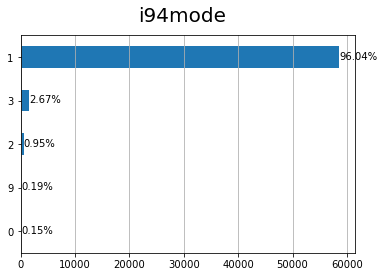

In [80]:
# 1	Air
# 2	Sea
# 3	Land
# 9	Not reported
freqdist_plot(immigration_table, "i94mode", figsize=(6,4))

In [73]:
#-> mean: 96.2% immigration used air transportation

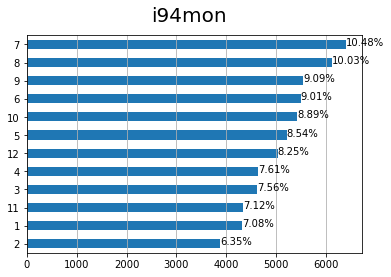

In [81]:
freqdist_plot(immigration_table, "i94mon", figsize=(6,4))

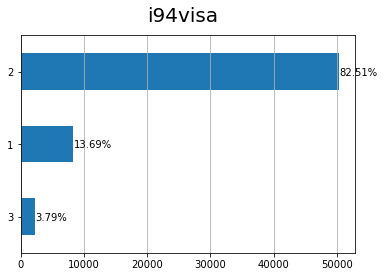

In [83]:
# '1':'Business',
# '2': 'Pleasure',
# '3' : 'Student'
freqdist_plot(immigration_table, "i94visa", figsize=(6,4))

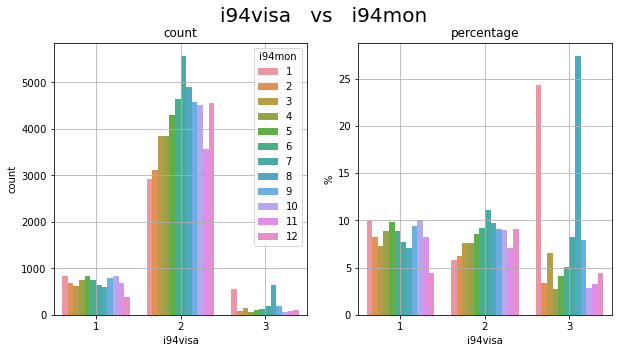

In [86]:
bivariate_plot(immigration_table, x="i94visa", y="i94mon", figsize=(10,5))

In [87]:
corr = corr_matrix(immigration_table, method="pearson", negative=False, lst_filters=["i94mon"], figsize=(15,1))

--- WARNING: Factorizing 182 labels of i94port ---
--- WARNING: Factorizing 366 labels of arrival_date ---
--- WARNING: Factorizing 529 labels of departure_date ---


TypeError: '<' not supported between instances of 'datetime.date' and 'int'

# columns meaning
cicid (int) : This is the unique Identifier --> Primary key

i94yr (int) : 4 digit year of the arrival

i94mon(int) : numeric month of the arrival

i94cit(string) : 3 digit code of origin city

I94res>>>> is country from where one has travelled. (No null values found).

i94port(string) : 3 character code of destination city --> Foreign key (used to map to USDemographics and City Temperature data)

arrdate (float) : arrival date of the departure (Convert it to timestamp format).Used to map to Date dimensions table ---> Foreign key

i94mode (float): 1 digit travel code (transportation)

I94addr>>>> is where the immigrants resides in USA . (Found null values).

depdate (float) the Departure Date from the USA. It is a SAS date numeric field that a permament format has not been applied. Please apply whichever date format works for you.

i94bir>>>>> Age of Respondent in Years

i94visa (string): reason for immigration

ENTDEPA - Arrival Flag - admitted or paroled into the U.S. - CIC does not use

ENTDEPD - Departure Flag - Departed, lost I-94 or is deceased - CIC does not use

ENTDEPU - Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use

MATFLAG - Match flag - Match of arrival and departure records

BIRYEAR>>>> 4 digit year of birth

INSNUM - INS number

AIRLINE >>>> Airline used to arrive in U.S

ADMNUM>>> Admission Number

FLTNO >>>> Flight number of Airline used to arrive in U.S

visatype (string): Visa type(Student, Job, etc.)Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

#### 2. I94 Descriptions

In [8]:
# get file path
bucket_name = './source/'

In [9]:
city_files = os.path.join(bucket_name,'I94_SAS_Labels_Descriptions.SAS')
city_files                          

'./source/I94_SAS_Labels_Descriptions.SAS'

In [10]:
with open(city_files) as f:
    f_content = f.read()
    f_content = f_content.replace('\t', '')

In [121]:
# f_content

In [122]:
# read file
def code_mapper(f_content, idx):
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'", "") for i in f_content2]
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    return dic

In [123]:
i94cit_res = code_mapper(f_content, "i94cntyl")
i94port = code_mapper(f_content, "i94prtl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business',
            '2': 'Pleasure',
            '3' : 'Student'}

In [70]:
# df_i94cit_res = pd.DataFrame.from_dict(i94cit_res, orient ='index') 
# df_i94cit_res.head()

In [71]:
df_i94cit_res= pd.DataFrame(list(i94cit_res.items()),columns = ['i94cit_res','origin_travelled_country'])
df_i94cit_res.head()

i94cit_res                                   origin_travelled_country
0        582  MEXICO Air Sea, and Not Reported (I-94, no land arrivals)
1        236                                                AFGHANISTAN
2        101                                                    ALBANIA
3        316                                                    ALGERIA
4        102                                                    ANDORRA

In [80]:
df_i94cit_res[df_i94cit_res['i94cit_res']=='206']

i94cit_res origin_travelled_country
91        206                HONG KONG

In [72]:
df_i94cit_res.to_csv('transformed/df_i94cit_res.csv',index=False)

In [124]:
df_i94port= pd.DataFrame(list(i94port.items()),columns = ['i94port','destination_city'])
df_i94port.head()

i94port              destination_city
0     ALC                     ALCAN, AK
1     ANC                 ANCHORAGE, AK
2     BAR  BAKER AAF - BAKER ISLAND, AK
3     DAC             DALTONS CACHE, AK
4     PIZ    DEW STATION PT LAY DEW, AK

In [125]:
# only df_i94port need to clean
df_i94port['city'] = df_i94port['destination_city'].str.split(',', expand=True)[0]
df_i94port['region'] = df_i94port['destination_city'].str.split(',', expand=True)[1]

In [127]:
df_i94port.drop(['destination_city'], axis=1, inplace=True)

In [136]:
df_i94port.head()

i94port                      city region
0     ALC                     ALCAN     AK
1     ANC                 ANCHORAGE     AK
2     BAR  BAKER AAF - BAKER ISLAND     AK
3     DAC             DALTONS CACHE     AK
4     PIZ    DEW STATION PT LAY DEW     AK

In [201]:
df_i94port[df_i94port['i94port']=='OGG']

i94port            city region
116     OGG  KAHULUI - MAUI     HI

In [137]:
df_i94port.to_csv('transformed/df_i94port.csv',index=False)

In [74]:
df_i94mode= pd.DataFrame(list(i94mode.items()),columns = ['i94mode','transportation'])
df_i94mode.head()

i94mode transportation
0       1            Air
1       2            Sea
2       3           Land
3       9   Not reported

In [137]:
df_i94mode.to_csv('transformed/df_i94mode.csv',index=False)

In [75]:
df_i94addr= pd.DataFrame(list(i94addr.items()),columns = ['i94addr','state'])
df_i94addr.head()

i94addr       state
0      AL     ALABAMA
1      AK      ALASKA
2      AZ     ARIZONA
3      AR    ARKANSAS
4      CA  CALIFORNIA

In [87]:
df_i94addr

i94addr              state
0       AL            ALABAMA
1       AK             ALASKA
2       AZ            ARIZONA
3       AR           ARKANSAS
4       CA         CALIFORNIA
5       CO           COLORADO
6       CT        CONNECTICUT
7       DE           DELAWARE
8       DC  DIST. OF COLUMBIA
9       FL            FLORIDA
10      GA            GEORGIA
11      GU               GUAM
12      HI             HAWAII
13      ID              IDAHO
14      IL           ILLINOIS
15      IN            INDIANA
16      IA               IOWA
17      KS             KANSAS
18      KY           KENTUCKY
19      LA          LOUISIANA
20      ME              MAINE
21      MD           MARYLAND
22      MA      MASSACHUSETTS
23      MI           MICHIGAN
24      MN          MINNESOTA
25      MS        MISSISSIPPI
26      MO           MISSOURI
27      MT            MONTANA
28      NC        N. CAROLINA
29      ND          N. DAKOTA
30      NE           NEBRASKA
31      NV             NEVADA
32      NH      NEW HAMPSHIRE
33      NJ         NEW JERSEY
34      NM         NEW MEXICO
35      NY           NEW YORK
36      OH               OHIO
37      OK           OKLAHOMA
38      OR             OREGON
39      PA       PENNSYLVANIA
40      PR        PUERTO RICO
41      RI       RHODE ISLAND
42      SC        S. CAROLINA
43      SD          S. DAKOTA
44      TN          TENNESSEE
45      TX              TEXAS
46      UT               UTAH
47      VT            VERMONT
48      VI     VIRGIN ISLANDS
49      VA           VIRGINIA
50      WV        W. VIRGINIA
51      WA         WASHINGTON
52      WI          WISCONSON
53      WY            WYOMING
54      99    All Other Codes

In [139]:
df_i94addr.to_csv('transformed/df_i94addr.csv',index=False)

In [140]:
df_i94visa= pd.DataFrame(list(i94visa.items()),columns = ['i94visa','immigration_reason'])
df_i94visa.head()

i94visa immigration_reason
0       1           Business
1       2           Pleasure
2       3            Student

In [141]:
df_i94visa.to_csv('transformed/df_i94visa.csv',index=False)

# immigration_data_sample.csv

In [206]:
immigration_sample = pd.read_csv('./source/immigration_data_sample.csv')

In [207]:
immigration_sample.head()

index      cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  \
0  2027561  4084316.0  2016.0     4.0   209.0   209.0     HHW  20566.0   
1  2171295  4422636.0  2016.0     4.0   582.0   582.0     MCA  20567.0   
2   589494  1195600.0  2016.0     4.0   148.0   112.0     OGG  20551.0   
3  2631158  5291768.0  2016.0     4.0   297.0   297.0     LOS  20572.0   
4  3032257   985523.0  2016.0     4.0   111.0   111.0     CHM  20550.0   

   i94mode i94addr  depdate  i94bir  i94visa  count  dtadfile visapost occup  \
0      1.0      HI  20573.0    61.0      2.0    1.0  20160422      NaN   NaN   
1      1.0      TX  20568.0    26.0      2.0    1.0  20160423      MTR   NaN   
2      1.0      FL  20571.0    76.0      2.0    1.0  20160407      NaN   NaN   
3      1.0      CA  20581.0    25.0      2.0    1.0  20160428      DOH   NaN   
4      3.0      NY  20553.0    19.0      2.0    1.0  20160406      NaN   NaN   

  entdepa entdepd  entdepu matflag  biryear   dtaddto gender  insnum airline  \
0       G       O      NaN       M   1955.0  07202016      F     NaN      JL   
1       G       R      NaN       M   1990.0  10222016      M     NaN     *GA   
2       G       O      NaN       M   1940.0  07052016      M     NaN      LH   
3       G       O      NaN       M   1991.0  10272016      M     NaN      QR   
4       Z       K      NaN       M   1997.0  07042016      F     NaN     NaN   

         admnum  fltno visatype  
0  5.658267e+10  00782       WT  
1  9.436200e+10  XBLNG       B2  
2  5.578047e+10  00464       WT  
3  9.478970e+10  00739       B2  
4  4.232257e+10   LAND       WT

In [235]:
immig_sam = immigration_sample[['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'i94mode','i94addr',
                                            'i94visa', 'matflag', 'airline', 'admnum', 'fltno', 'arrdate', 'depdate']]

In [273]:
immigrant_sam = immigration_sample[['admnum', 'i94bir', 'gender', 'biryear', 'visatype']]

In [236]:
immig_sam.head()

cicid   i94yr  i94mon  i94cit  i94res i94port  i94mode i94addr  \
0  4084316.0  2016.0     4.0   209.0   209.0     HHW      1.0      HI   
1  4422636.0  2016.0     4.0   582.0   582.0     MCA      1.0      TX   
2  1195600.0  2016.0     4.0   148.0   112.0     OGG      1.0      FL   
3  5291768.0  2016.0     4.0   297.0   297.0     LOS      1.0      CA   
4   985523.0  2016.0     4.0   111.0   111.0     CHM      3.0      NY   

   i94visa matflag airline        admnum  fltno  arrdate  depdate  
0      2.0       M      JL  5.658267e+10  00782  20566.0  20573.0  
1      2.0       M     *GA  9.436200e+10  XBLNG  20567.0  20568.0  
2      2.0       M      LH  5.578047e+10  00464  20551.0  20571.0  
3      2.0       M      QR  9.478970e+10  00739  20572.0  20581.0  
4      2.0       M     NaN  4.232257e+10   LAND  20550.0  20553.0

In [274]:
immigrant_sam.head()

admnum  i94bir gender  biryear visatype
0  5.658267e+10    61.0      F   1955.0       WT
1  9.436200e+10    26.0      M   1990.0       B2
2  5.578047e+10    76.0      M   1940.0       WT
3  9.478970e+10    25.0      M   1991.0       B2
4  4.232257e+10    19.0      F   1997.0       WT

In [237]:
immig_sam['arrdate'] = pd.to_timedelta(immig_sam['arrdate'], unit='d') + pd.datetime(1960, 1, 1)
immig_sam['depdate'] = pd.to_timedelta(immig_sam['depdate'], unit='d') + pd.datetime(1960, 1, 1)

In [238]:
immig_sam.rename(columns={'arrdate':'arrival_date','depdate':'departure_date'},  inplace=True)

In [239]:
immig_sam.dtypes

cicid                    float64
i94yr                    float64
i94mon                   float64
i94cit                   float64
i94res                   float64
i94port                   object
i94mode                  float64
i94addr                   object
i94visa                  float64
matflag                   object
airline                   object
admnum                   float64
fltno                     object
arrival_date      datetime64[ns]
departure_date    datetime64[ns]
dtype: object

In [240]:
immig_sam[['cicid','admnum']] = immig_sam[['cicid','admnum']].astype('int64')

In [241]:
immig_sam[['i94yr', 'i94mon', 'i94cit', 'i94res', 'i94mode', 'i94visa']] = \
immig_sam[['i94yr', 'i94mon', 'i94cit', 'i94res', 'i94mode', 'i94visa']].astype('int')

In [275]:
immigrant_sam[['admnum']] = immigrant_sam[['admnum']].astype('int64')
immigrant_sam[['i94bir', 'biryear']] = immigrant_sam[['i94bir', 'biryear']].astype('int')

In [276]:
immigrant_sam.dtypes

admnum       int64
i94bir       int32
gender      object
biryear      int32
visatype    object
dtype: object

In [242]:
immig_sam.head()

cicid  i94yr  i94mon  i94cit  i94res i94port  i94mode i94addr  i94visa  \
0  4084316   2016       4     209     209     HHW        1      HI        2   
1  4422636   2016       4     582     582     MCA        1      TX        2   
2  1195600   2016       4     148     112     OGG        1      FL        2   
3  5291768   2016       4     297     297     LOS        1      CA        2   
4   985523   2016       4     111     111     CHM        3      NY        2   

  matflag airline       admnum  fltno arrival_date departure_date  
0       M      JL  56582674633  00782   2016-04-22     2016-04-29  
1       M     *GA  94361995930  XBLNG   2016-04-23     2016-04-24  
2       M      LH  55780468433  00464   2016-04-07     2016-04-27  
3       M      QR  94789696030  00739   2016-04-28     2016-05-07  
4       M     NaN  42322572633   LAND   2016-04-06     2016-04-09

In [281]:
immigrant_sam['admnum'].value_counts()

56582674633    1
92845848430    1
59398669033    1
93143927330    1
94900912430    1
56462929533    1
94540124330    1
59330275733    1
56259865933    1
55445906133    1
56497185333    1
55711385733    1
92947713030    1
56092425733    1
55744924733    1
47864220433    1
92764761030    1
55558618633    1
56422616333    1
55510760333    1
59446060833    1
59082045033    1
92607990930    1
45144392433    1
47114299033    1
55803487833    1
93469478830    1
59332985333    1
84429099430    1
94972499530    1
93506635930    1
94827964030    1
3730331127     1
92926898230    1
92977558830    1
93931378930    1
93135058630    1
94817007130    1
55751892233    1
55427127333    1
92980481030    1
55598084833    1
93442531530    1
93836369030    1
59234646233    1
55896662333    1
94952246730    1
93808239330    1
55629162533    1
55667149133    1
59559534033    1
92599634530    1
92551642430    1
94532630630    1
49260591533    1
56433360633    1
55841759533    1
92810146030    1
94416391830   

In [234]:
immig_sam.to_csv('./transformed/immig_sam.csv', index=False)

In [279]:
immigrant_sam.to_csv('./transformed/immigrant_sam.csv', index=False)

#### 3. Airport Code Table, World Temperature Data, U.S. City Demographic Data

In [283]:
# get file path
airpot_files = 'airport-codes_csv.csv'
temperature_files = 'GlobalLandTemperaturesByCity.csv'
demographic_files = 'us-cities-demographics.csv'

bucket_name = 's3://lcw-udacity-capstone/source/'
# bucket_name = './source/'
airport_files = os.path.join(bucket_name, airpot_files)
temperature_files = os.path.join(bucket_name, temperature_files)
demographic_files = os.path.join(bucket_name, demographic_files)

In [284]:
# read file
df_airport = pd.read_csv(airport_files, sep=',')
df_temperature = pd.read_csv(temperature_files, sep=',')
df_demographic = pd.read_csv(demographic_files,sep=';')

PermissionError: Forbidden

## test: use spark to read csv

In [ ]:
df_airport = spark.read.options(header='true')\
                        .csv(airpot_files)                     

In [ ]:
df_airport = spark.read.format('csv').options(header='true')\
                        .load(airpot_files)
                        

In [ ]:
df_airport.limit(10).toPandas()

In [ ]:
df_airport.printSchema()

## return to use pandas

In [46]:
df_airport.count()

ident           55075
type            55075
name            55075
elevation_ft    48069
continent       27356
iso_country     54828
iso_region      55075
municipality    49399
gps_code        41030
iata_code        9189
local_code      28686
coordinates     55075
dtype: int64

In [95]:
df_airport['type'].unique().shape[0]

7

In [96]:
df_airport['type'].value_counts().count()

7

In [97]:
df_airport.T.apply(lambda x: x.nunique(), axis=1)

ident           55075
type                7
name            52144
elevation_ft     5449
continent           6
iso_country       243
iso_region       2810
municipality    27133
gps_code        40850
iata_code        9042
local_code      27436
coordinates     54874
dtype: int64

In [262]:
df_airport['type'].value_counts()

small_airport     33965
heliport          11287
medium_airport     4550
closed             3606
seaplane_base      1016
large_airport       627
balloonport          24
Name: type, dtype: int64

In [264]:
df_airport[df_airport['local_code']=='NYC']

Empty DataFrame
Columns: [ident, type, name, elevation_ft, continent, iso_country, iso_region, municipality, gps_code, iata_code, local_code, coordinates]
Index: []

In [101]:
# To filter the closed airports
airport_table = df_airport[~df_airport['type'].isin(['closed'])]

In [102]:
# To filter the airports in US
airport_table = airport_table[airport_table['iso_country']=='US']

In [103]:
airport_table = airport_table[~airport_table['local_code'].isna()]

In [98]:
airport_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21125 entries, 0 to 54896
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         21125 non-null  object 
 1   type          21125 non-null  object 
 2   name          21125 non-null  object 
 3   elevation_ft  20976 non-null  float64
 4   continent     1 non-null      object 
 5   iso_country   21125 non-null  object 
 6   iso_region    21125 non-null  object 
 7   municipality  21112 non-null  object 
 8   gps_code      20835 non-null  object 
 9   iata_code     1947 non-null   object 
 10  local_code    21125 non-null  object 
 11  coordinates   21125 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.1+ MB


In [99]:
airport_table['local_code'].value_counts().head(10)

LAN    5
AMA    5
TOL    4
BAC    4
SER    4
HRR    4
GRN    4
CAR    4
CHA    4
ROS    4
Name: local_code, dtype: int64

In [261]:
airport_table[airport_table['local_code']=='LOS']

Empty DataFrame
Columns: [airport_id, ident, type, name, elevation_ft, iso_country, iso_region, municipality, gps_code, local_code, longitude, latitude]
Index: []

In [106]:
airport_table['longitude'] = airport_table['coordinates'].str.split(',', expand=True)[0].astype('float').round(2)
airport_table['latitude'] = airport_table['coordinates'].str.split(',', expand=True)[1].astype('float').round(2)

In [108]:
airport_table['iso_region'] = airport_table['iso_region'].str.split('-', expand=True)[1]

In [102]:
# airport_table = pd.concat([airport_table.drop('coordinates',axis=1),\
#                            airport_table['coordinates'].str.split(',', expand=True)], axis=1)

In [103]:
airport_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21125 entries, 0 to 54896
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         21125 non-null  object 
 1   type          21125 non-null  object 
 2   name          21125 non-null  object 
 3   elevation_ft  20976 non-null  float64
 4   continent     1 non-null      object 
 5   iso_country   21125 non-null  object 
 6   iso_region    21125 non-null  object 
 7   municipality  21112 non-null  object 
 8   gps_code      20835 non-null  object 
 9   iata_code     1947 non-null   object 
 10  local_code    21125 non-null  object 
 11  coordinates   21125 non-null  object 
 12  longitude     21125 non-null  float64
 13  latitude      21125 non-null  float64
dtypes: float64(3), object(11)
memory usage: 2.4+ MB


In [146]:
# airport_table1.rename(columns={0:'longitude'})
# airport_table1.rename(columns={1:'latitude'})
airport_table.head(20)

ident           type                                name  elevation_ft  \
0    00A       heliport                   Total Rf Heliport          11.0   
1   00AA  small_airport                Aero B Ranch Airport        3435.0   
2   00AK  small_airport                        Lowell Field         450.0   
3   00AL  small_airport                        Epps Airpark         820.0   
5   00AS  small_airport                      Fulton Airport        1100.0   
6   00AZ  small_airport                      Cordes Airport        3810.0   
7   00CA  small_airport             Goldstone /Gts/ Airport        3038.0   
8   00CL  small_airport                 Williams Ag Airport          87.0   
9   00CN       heliport     Kitchen Creek Helibase Heliport        3350.0   
11  00FA  small_airport                 Grass Patch Airport          53.0   
12  00FD       heliport                  Ringhaver Heliport          25.0   
13  00FL  small_airport                   River Oak Airport          35.0   
14  00GA  small_airport                    Lt World Airport         700.0   
15  00GE       heliport                    Caffrey Heliport         957.0   
16  00HI       heliport                  Kaupulehu Heliport          43.0   
17  00ID  small_airport                Delta Shores Airport        2064.0   
18  00IG  small_airport                       Goltl Airport        3359.0   
19  00II       heliport  Bailey Generation Station Heliport         600.0   
20  00IL  small_airport                      Hammer Airport         840.0   
21  00IN       heliport     St Mary Medical Center Heliport         634.0   

   iso_country iso_region  municipality gps_code local_code  longitude  \
0           US         PA      Bensalem      00A        00A     -74.93   
1           US         KS         Leoti     00AA       00AA    -101.47   
2           US         AK  Anchor Point     00AK       00AK    -151.70   
3           US         AL       Harvest     00AL       00AL     -86.77   
5           US         OK          Alex     00AS       00AS     -97.82   
6           US         AZ        Cordes     00AZ       00AZ    -112.17   
7           US         CA       Barstow     00CA       00CA    -116.89   
8           US         CA         Biggs     00CL       00CL    -121.76   
9           US         CA   Pine Valley     00CN       00CN    -116.46   
11          US         FL      Bushnell     00FA       00FA     -82.22   
12          US         FL     Riverview     00FD       00FD     -82.35   
13          US         FL    Okeechobee     00FL       00FL     -80.97   
14          US         GA      Lithonia     00GA       00GA     -84.07   
15          US         GA         Hiram     00GE       00GE     -84.73   
16          US         HI   Kailua/Kona     00HI       00HI    -155.98   
17          US         ID    Clark Fork     00ID       00ID    -116.21   
18          US         KS      McDonald     00IG       00IG    -101.40   
19          US         IN    Chesterton     00II       00II     -87.12   
20          US         IL          Polo     00IL       00IL     -89.56   
21          US         IN        Hobart     00IN       00IN     -87.26   

    latitude  
0      40.07  
1      38.70  
2      59.95  
3      34.86  
5      34.94  
6      34.31  
7      35.35  
8      39.43  
9      32.73  
11     28.65  
12     28.85  
13     27.23  
14     33.77  
15     33.88  
16     19.83  
17     48.15  
18     39.72  
19     41.64  
20     41.98  
21     41.51

In [155]:
airport_table['type'].value_counts()

small_airport     13498
heliport           6149
medium_airport      686
seaplane_base       557
large_airport       167
balloonport          18
Name: type, dtype: int64

In [130]:
airport_table.drop(['coordinates','continent','iata_code'], axis=1, inplace=True)

In [131]:
airport_table[airport_table['type']=='large_airport']

ident           type  \
26007  KABQ  large_airport   
26026  KADW  large_airport   
26039  KAFW  large_airport   
26043  KAGS  large_airport   
26076  KAMA  large_airport   
26128  KATL  large_airport   
26137  KAUS  large_airport   
26141  KAVL  large_airport   
26165  KBAB  large_airport   
26166  KBAD  large_airport   
26183  KBDL  large_airport   
26198  KBFI  large_airport   
26208  KBGR  large_airport   
26212  KBHM  large_airport   
26218  KBIL  large_airport   
26240  KBLV  large_airport   
26244  KBMI  large_airport   
26248  KBNA  large_airport   
26253  KBOI  large_airport   
26254  KBOS  large_airport   
26279  KBUF  large_airport   
26293  KBWI  large_airport   
26332  KCAE  large_airport   
26342  KCBM  large_airport   
26380  KCHA  large_airport   
26387  KCHS  large_airport   
26391  KCID  large_airport   
26408  KCLE  large_airport   
26415  KCLT  large_airport   
26418  KCMH  large_airport   
26460  KCRP  large_airport   
26464  KCRW  large_airport   
26483  KCVG  large_airport   
26487  KCVS  large_airport   
26540  KDAB  large_airport   
26543  KDAL  large_airport   
26546  KDAY  large_airport   
26548  KDBQ  large_airport   
26549  KDCA  large_airport   
26558  KDEN  large_airport   
26563  KDFW  large_airport   
26575  KDLF  large_airport   
26576  KDLH  large_airport   
26590  KDOV  large_airport   
26604  KDSM  large_airport   
26611  KDTW  large_airport   
26636  KDYS  large_airport   
27005  KEDW  large_airport   
27049  KEND  large_airport   
27061  KERI  large_airport   
27086  KEWR  large_airport   
27173  KFFO  large_airport   
27189  KFLL  large_airport   
27224  KFSM  large_airport   
27232  KFTW  large_airport   
27237  KFWA  large_airport   
27317  KGEG  large_airport   
27364  KGPT  large_airport   
27367  KGRB  large_airport   
27376  KGSB  large_airport   
27378  KGSO  large_airport   
27379  KGSP  large_airport   
27389  KGUS  large_airport   
27466  KHIB  large_airport   
27486  KHMN  large_airport   
27500  KHOU  large_airport   
27524  KHSV  large_airport   
27528  KHTS  large_airport   
27594  KIAD  large_airport   
27596  KIAH  large_airport   
27601  KICT  large_airport   
27631  KIND  large_airport   
27668  KJAN  large_airport   
27671  KJAX  large_airport   
27679  KJFK  large_airport   
27687  KJLN  large_airport   
27793  KLAS  large_airport   
27795  KLAX  large_airport   
27796  KLBB  large_airport   
27807  KLCK  large_airport   
27815  KLEX  large_airport   
27816  KLFI  large_airport   
27818  KLFT  large_airport   
27819  KLGA  large_airport   
27834  KLIT  large_airport   
27880  KLTS  large_airport   
27883  KLUF  large_airport   
27990  KMBS  large_airport   
27997  KMCF  large_airport   
27998  KMCI  large_airport   
28001  KMCO  large_airport   
28012  KMDW  large_airport   
28017  KMEM  large_airport   
28029  KMGE  large_airport   
28032  KMGM  large_airport   
28044  KMIA  large_airport   
28057  KMKE  large_airport   
28072  KMLI  large_airport   
28077  KMLU  large_airport   
28098  KMOB  large_airport   
28129  KMSN  large_airport   
28131  KMSP  large_airport   
28134  KMSY  large_airport   
28147  KMUO  large_airport   
28322  KOAK  large_airport   
28350  KOKC  large_airport   
28369  KOMA  large_airport   
28378  KONT  large_airport   
28392  KORD  large_airport   
28394  KORF  large_airport   
28537  KPAM  large_airport   
28544  KPBI  large_airport   
28554  KPDX  large_airport   
28568  KPHF  large_airport   
28572  KPHL  large_airport   
28576  KPHX  large_airport   
28577  KPIA  large_airport   
28584  KPIT  large_airport   
28673  KPWM  large_airport   
29764  KRDU  large_airport   
29768  KRFD  large_airport   
29775  KRIC  large_airport   
29798  KRND  large_airport   
29801  KRNO  large_airport   
29805  KROA  large_airport   
29806  KROC  large_airport   
29824  KRST  large_airport   
29826  KRSW  large_airport   
29900  KSAN  large_airport   
29902  KSAT  large_airport   
29903  KSAV  large_airport   
29909  KSBN  large_airport   
29923  KSDF  lar

In [260]:
airport_table[airport_table['municipality']=='Peoria']

airport_id ident           type  \
2804         3001  2AZ2       heliport   
2969         3175  2IS1       heliport   
7649         8145   7B1       heliport   
11505       23931  IL04       heliport   
12196       25525  K3MY  small_airport   
14715       28577  KPIA  large_airport   
15627       31834  LL36       heliport   
15628       31835  LL37       heliport   
17914       38064   P48  small_airport   
18970       47756  TE99  small_airport   

                                                        name  elevation_ft  \
2804                              Sunstate-Glendale Helistop        1135.0   
2969                               Proctor Hospital Heliport         640.0   
7649                                        Rainbow Heliport         700.0   
11505          Methodist Medical Center of Illinois Heliport         631.0   
12196                         Mount Hawley Auxiliary Airport         786.0   
14715  General Wayne A. Downing Peoria International Airport         660.0   
15627                            Exposition Gardens Heliport         760.0   
15628              OSF Saint Francis Medical Center Heliport         585.0   
17914                                Pleasant Valley Airport        1580.0   
18970                                    Barnstormer Airport         625.0   

      iso_country iso_region municipality gps_code local_code  longitude  \
2804           US         AZ       Peoria     2AZ2       2AZ2    -112.23   
2969           US         IL       Peoria     2IS1       2IS1     -89.59   
7649           US         IL       Peoria      7B1        7B1     -89.68   
11505          US         IL       Peoria     IL04       IL04     -89.59   
12196          US         IL       Peoria     K3MY        3MY     -89.61   
14715          US         IL       Peoria     KPIA        PIA     -89.69   
15627          US         IL       Peoria     LL36       LL36     -89.62   
15628          US         IL       Peoria     LL37       LL37     -89.59   
17914          US         AZ       Peoria      P48        P48    -112.25   
18970          US         TX       Peoria     TE99       TE99     -97.25   

       latitude  
2804      33.57  
2969      40.75  
7649      40.78  
11505     40.70  
12196     40.80  
14715     40.66  
15627     40.76  
15628     40.70  
17914     33.80  
18970     32.02

In [154]:
# drop duplicates of local_code, and keep the first
airport_table = airport_table.drop_duplicates(subset=['local_code'], keep='first', inplace=False)

In [156]:
airport_table['local_code'].value_counts()

00A        1
LAX        1
LAS        1
LAR        1
LAN        1
LAM        1
LAL        1
LAF        1
LAA        1
L94        1
L88        1
L84        1
L83        1
L77        1
L73        1
L72        1
L71        1
L70        1
L66        1
LAW        1
LBB        1
K61        1
LBE        1
LEW        1
LEM        1
LEE        1
LEB        1
LDM        1
LDJ        1
LCQ        1
LCK        1
LCI        1
LCH        1
LCG        1
LBX        1
LBT        1
LBR        1
LBO        1
LBL        1
LBF        1
L65        1
L64        1
L62        1
L47        1
KNB        1
KLS        1
KKL        1
KIC        1
KKI        1
KKB        1
K94        1
K89        1
K88        1
K83        1
K82        1
K81        1
K79        1
K78        1
K77        1
K75        1
K74        1
KKU        1
L00        1
L04        1
L31        1
L45        1
L41        1
L39        1
REG        1
L35        1
L33        1
L32        1
L26        1
L05        1
L23        1
L22        1
L19        1

In [247]:
airport_table = airport_table.reset_index()
airport_table.rename(columns = {'index':'airport_id'}, inplace = True)

In [250]:
airport_table.head()

airport_id ident           type                  name  elevation_ft  \
0           0   00A       heliport     Total Rf Heliport          11.0   
1           1  00AA  small_airport  Aero B Ranch Airport        3435.0   
2           2  00AK  small_airport          Lowell Field         450.0   
3           3  00AL  small_airport          Epps Airpark         820.0   
4           5  00AS  small_airport        Fulton Airport        1100.0   

  iso_country iso_region  municipality gps_code local_code  longitude  \
0          US         PA      Bensalem      00A        00A     -74.93   
1          US         KS         Leoti     00AA       00AA    -101.47   
2          US         AK  Anchor Point     00AK       00AK    -151.70   
3          US         AL       Harvest     00AL       00AL     -86.77   
4          US         OK          Alex     00AS       00AS     -97.82   

   latitude  
0     40.07  
1     38.70  
2     59.95  
3     34.86  
4     34.94

In [251]:
airport_table.to_csv('transformed/us_airport.csv',index=False)

In [200]:
airport_table[airport_table['local_code']=='OGG']

ident            type             name  elevation_ft iso_country  \
38756  PHOG  medium_airport  Kahului Airport          54.0          US   

      iso_region municipality gps_code local_code  longitude  latitude  
38756         HI      Kahului     PHOG        OGG    -156.43      20.9

In [31]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [79]:
df_temperature.count()

dt                               8599212
AverageTemperature               8235082
AverageTemperatureUncertainty    8235082
City                             8599212
Country                          8599212
Latitude                         8599212
Longitude                        8599212
dtype: int64

In [80]:
df_temperature.T.apply(lambda x: x.nunique(), axis=1)

dt                                 3239
AverageTemperature               103481
AverageTemperatureUncertainty     10902
City                               3448
Country                             159
Latitude                             73
Longitude                          1227
dtype: int64

In [81]:
df_temperature.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E

In [179]:
# To filter out the rows what have null value
temperature_table = df_temperature[~df_temperature['AverageTemperature'].isna()]

In [83]:
temperature_table.count()

dt                               8235082
AverageTemperature               8235082
AverageTemperatureUncertainty    8235082
City                             8235082
Country                          8235082
Latitude                         8235082
Longitude                        8235082
dtype: int64

In [33]:
temperature_table.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [182]:
# transport the type of 'dt' to <datetime>
temperature_table.loc[:,'dt'] = pd.to_datetime(temperature_table.loc[:,'dt'])

In [183]:
# temperature_table[(temperature_table['dt']>'1999-12-31')].sort_values(by=['City','dt'],ascending=False).head(100)

In [184]:
# In view of the impact of human activities on climate in recent years, we screened the data after 1985 
# to calculate the average temperature
temperature_table = temperature_table[(temperature_table['dt']>'1985-12-31')]

In [185]:
temperature_table.count()

dt                               1165760
AverageTemperature               1165760
AverageTemperatureUncertainty    1165760
City                             1165760
Country                          1165760
Latitude                         1165760
Longitude                        1165760
dtype: int64

In [37]:
temperature_table.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [186]:
temperature_table['month'] = temperature_table['dt'].dt.month

In [180]:
temperature_table.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
5  1744-04-01               5.788                          3.624  Århus   
6  1744-05-01              10.644                          1.283  Århus   
7  1744-06-01              14.051                          1.347  Århus   
8  1744-07-01              16.082                          1.396  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
5  Denmark   57.05N    10.33E  
6  Denmark   57.05N    10.33E  
7  Denmark   57.05N    10.33E  
8  Denmark   57.05N    10.33E

In [93]:
# temperature_table.loc[:,'Latitude'] = temperature_table['Latitude'].str.replace("N", "")
# temperature_table.loc[:,'Longitude'] = temperature_table['Longitude'].str.replace("E", "")

In [187]:
# delete the letter E what in the columns of 'latitude' and 'longitude'
temperature_table.loc[:,'Latitude'] = temperature_table.apply(lambda x: x['Latitude'][:-1], axis = 1)
temperature_table.loc[:,'Longitude'] = temperature_table.apply(lambda x: x['Longitude'][:-1], axis = 1)

In [188]:
temperature_table['Longitude'] = '-' + temperature_table['Longitude'] 

In [189]:
temperature_table.sort_values(by=['City','month'],ascending=True).head(100)

dt  AverageTemperature  AverageTemperatureUncertainty      City  \
17149 1986-01-01               8.213                          0.404  A Coruña   
17161 1987-01-01               8.263                          0.520  A Coruña   
17173 1988-01-01              10.136                          0.265  A Coruña   
17185 1989-01-01               8.857                          0.646  A Coruña   
17197 1990-01-01               8.685                          0.276  A Coruña   
17209 1991-01-01               8.451                          0.205  A Coruña   
17221 1992-01-01               7.053                          0.385  A Coruña   
17233 1993-01-01               9.833                          0.455  A Coruña   
17245 1994-01-01               9.249                          0.344  A Coruña   
17257 1995-01-01               9.751                          0.214  A Coruña   
17269 1996-01-01              10.261                          0.229  A Coruña   
17281 1997-01-01               8.893                          0.213  A Coruña   
17293 1998-01-01              10.559                          0.231  A Coruña   
17305 1999-01-01               9.441                          0.251  A Coruña   
17317 2000-01-01               7.468                          0.318  A Coruña   
17329 2001-01-01               9.849                          0.241  A Coruña   
17341 2002-01-01              10.562                          0.464  A Coruña   
17353 2003-01-01               8.688                          0.287  A Coruña   
17365 2004-01-01              10.304                          0.272  A Coruña   
17377 2005-01-01               8.781                          0.635  A Coruña   
17389 2006-01-01               7.722                          0.363  A Coruña   
17401 2007-01-01               9.502                          0.221  A Coruña   
17413 2008-01-01              10.293                          0.247  A Coruña   
17425 2009-01-01               8.366                          0.298  A Coruña   
17437 2010-01-01               8.469                          0.233  A Coruña   
17449 2011-01-01               9.668                          0.390  A Coruña   
17461 2012-01-01               8.703                          0.501  A Coruña   
17473 2013-01-01               9.773                          0.377  A Coruña   
17150 1986-02-01               8.372                          0.296  A Coruña   
17162 1987-02-01               9.270                          0.339  A Coruña   
17174 1988-02-01               9.771                          0.271  A Coruña   
17186 1989-02-01              10.258                          0.404  A Coruña   
17198 1990-02-01              12.180                          0.254  A Coruña   
17210 1991-02-01               7.954                          0.223  A Coruña   
17222 1992-02-01               9.548                          0.354  A Coruña   
17234 1993-02-01               9.737                          0.659  A Coruña   
17246 1994-02-01               8.818                          0.323  A Coruña   
17258 1995-02-01              10.358                          0.290  A Coruña   
17270 1996-02-01               8.338                          0.264  A Coruña   
17282 1997-02-01              11.486                          0.229  A Coruña   
17294 1998-02-01              12.009                          0.290  A Coruña   
17306 1999-02-01               9.021                          0.292  A Coruña   
17318 2000-02-01              11.199                          0.429  A Coruña   
17330 2001-02-01              10.412                          0.346  A Coruña   
17342 2002-02-01              10.780                          0.316  A Coruña   
17354 2003-02-01               9.159                          0.198  A Coruña   
17366 2004-02-01               9.667                          0.311  A Coruña   
17378 2005-02-01               7.176                          0.291  A Coruña   
17390 2006-02-01               8.029         

In [190]:
temperature_table.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
month                            0
dtype: int64

In [191]:
temperature_table['Latitude'] = temperature_table['Latitude'].astype('float')
temperature_table['Longitude'] = temperature_table['Longitude'].astype('float')

In [98]:
temperature_table_stat = temperature_table.groupby('City').agg(['min','max','nunique'])
temperature_table_stat.head(10)

dt                    AverageTemperature                  \
                  min        max nunique                min     max nunique   
City                                                                          
A Coruña   1986-01-01 2013-08-01     332              7.053  21.913     326   
Aachen     1986-01-01 2013-08-01     332             -4.923  22.812     330   
Aalborg    1986-01-01 2013-08-01     332             -5.391  20.883     327   
Aba        1986-01-01 2013-08-01     332             25.168  30.036     317   
Abadan     1986-01-01 2013-08-01     332             10.283  38.531     331   
Abakaliki  1986-01-01 2013-08-01     332             25.168  30.036     317   
Abakan     1986-01-01 2013-08-01     332            -28.003  21.215     332   
Abbotsford 1986-01-01 2013-09-01     333             -2.710  17.615     327   
Abengourou 1986-01-01 2013-08-01     332             24.626  30.743     327   
Abeokuta   1986-01-01 2013-08-01     332             24.135  30.313     317   

           AverageTemperatureUncertainty                       Country  \
                                     min    max nunique            min   
City                                                                     
A Coruña                           0.172  1.621     232          Spain   
Aachen                             0.074  0.481     186        Germany   
Aalborg                            0.077  0.549     206        Denmark   
Aba                                0.157  1.219     256        Nigeria   
Abadan                             0.166  3.792     252           Iran   
Abakaliki                          0.157  1.219     256        Nigeria   
Abakan                             0.101  2.785     253         Russia   
Abbotsford                         0.079  1.056     205         Canada   
Abengourou                         0.069  1.443     231  Côte D'Ivoire   
Abeokuta                           0.102  1.570     248        Nigeria   

                                  Latitude                Longitude          \
                      max nunique      min    max nunique       min     max   
City                                                                          
A Coruña            Spain       1    42.59  42.59       1      8.73    8.73   
Aachen            Germany       1    50.63  50.63       1      6.34    6.34   
Aalborg           Denmark       1    57.05  57.05       1     10.33   10.33   
Aba               Nigeria       1     5.63   5.63       1      8.07    8.07   
Abadan               Iran       1    29.74  29.74       1     48.00   48.00   
Abakaliki         Nigeria       1     5.63   5.63       1      8.07    8.07   
Abakan             Russia       1    53.84  53.84       1     91.36   91.36   
Abbotsford         Canada       1    49.03  49.03       1    122.45  122.45   
Abengourou  Côte D'Ivoire       1     7.23   7.23       1      4.05    4.05   
Abeokuta          Nigeria       1     7.23   7.23       1      4.05    4.05   

                   month              
           nunique   min max nunique  
City                                  
A Coruña         1     1  12      12  
Aachen           1     1  12      12  
Aalborg          1     1  12      12  
Aba              1     1  12      12  
Abadan           1     1  12      12  
Abakaliki        1     1  12      12  
Abakan           1     1  12      12  
Abbotsford       1     1  12      12  
Abengourou       1     1  12      12  
Abeokuta         1     1  12      12

In [44]:
temperature_table.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                float64
Longitude                               float64
month                                     int64
dtype: object

In [100]:
# temperature_table.loc[:,'Latitude'] = pd.to_numeric(temperature_table['Latitude'])
# temperature_table.loc[:,'Longitude'] = pd.to_numeric(temperature_table['Longitude'])

In [103]:
temperature_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165760 entries, 0 to 1165759
Data columns (total 8 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   dt                             1165760 non-null  object 
 1   AverageTemperature             1165760 non-null  float64
 2   AverageTemperatureUncertainty  1165760 non-null  float64
 3   City                           1165760 non-null  object 
 4   Country                        1165760 non-null  object 
 5   Latitude                       1165760 non-null  float64
 6   Longitude                      1165760 non-null  float64
 7   month                          1165760 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 71.2+ MB


In [104]:
temperature_table.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                         float64
Longitude                        float64
month                              int64
dtype: object

In [113]:
temperature_table[temperature_table['Country']=='China'].head(10)

dt  AverageTemperature  AverageTemperatureUncertainty    City  \
1328  1986-01-01             -14.055                          0.615  Ürümqi   
1329  1986-02-01             -12.080                          0.743  Ürümqi   
1330  1986-03-01              -1.430                          0.556  Ürümqi   
1331  1986-04-01               8.782                          0.321  Ürümqi   
1332  1986-05-01              18.392                          0.325  Ürümqi   
1333  1986-06-01              20.562                          0.272  Ürümqi   
1334  1986-07-01              25.018                          0.226  Ürümqi   
1335  1986-08-01              22.438                          0.372  Ürümqi   
1336  1986-09-01              17.216                          0.288  Ürümqi   
1337  1986-10-01               7.236                          0.410  Ürümqi   

     Country  Latitude  Longitude  month  
1328   China      44.2       87.2      1  
1329   China      44.2       87.2      2  
1330   China      44.2       87.2      3  
1331   China      44.2       87.2      4  
1332   China      44.2       87.2      5  
1333   China      44.2       87.2      6  
1334   China      44.2       87.2      7  
1335   China      44.2       87.2      8  
1336   China      44.2       87.2      9  
1337   China      44.2       87.2     10

In [270]:
temperature_table[temperature_table['City']=='Louisville']

dt  AverageTemperature  AverageTemperatureUncertainty  \
4372245 1986-01-01               0.872                          0.262   
4372246 1986-02-01               4.549                          0.316   
4372247 1986-03-01               8.675                          0.299   
4372248 1986-04-01              14.489                          0.238   
4372249 1986-05-01              19.376                          0.317   
4372250 1986-06-01              23.822                          0.317   
4372251 1986-07-01              26.583                          0.347   
4372252 1986-08-01              23.041                          0.315   
4372253 1986-09-01              22.275                          0.236   
4372254 1986-10-01              14.789                          0.209   
4372255 1986-11-01               7.853                          0.271   
4372256 1986-12-01               2.523                          0.170   
4372257 1987-01-01               0.508                          0.366   
4372258 1987-02-01               4.009                          0.287   
4372259 1987-03-01               8.978                          0.248   
4372260 1987-04-01              12.341                          0.202   
4372261 1987-05-01              21.480                          0.249   
4372262 1987-06-01              24.147                          0.225   
4372263 1987-07-01              25.475                          0.219   
4372264 1987-08-01              25.417                          0.188   
4372265 1987-09-01              20.941                          0.421   
4372266 1987-10-01              10.806                          0.393   
4372267 1987-11-01              10.217                          0.278   
4372268 1987-12-01               4.277                          0.238   
4372269 1988-01-01              -0.820                          0.226   
4372270 1988-02-01               1.617                          0.189   
4372271 1988-03-01               7.492                          0.326   
4372272 1988-04-01              12.958                          0.335   
4372273 1988-05-01              18.228                          0.287   
4372274 1988-06-01              23.297                          0.303   
4372275 1988-07-01              25.970                          0.212   
4372276 1988-08-01              25.911                          0.161   
4372277 1988-09-01              20.379                          0.143   
4372278 1988-10-01              10.322                          0.251   
4372279 1988-11-01               8.473                          0.300   
4372280 1988-12-01               3.052                          0.113   
4372281 1989-01-01               4.902                          0.246   
4372282 1989-02-01               1.125                          0.297   
4372283 1989-03-01               9.067                          0.252   
4372284 1989-04-01              12.791                          0.296   
4372285 1989-05-01              16.466                          0.240   
4372286 1989-06-01              22.570                          0.283   
4372287 1989-07-01              24.897                          0.185   
4372288 1989-08-01              23.951                          0.236   
4372289 1989-09-01              20.107                          0.249   
4372290 1989-10-01              14.022                          0.304   
4372291 1989-11-01               8.117                          0.188   
4372292 1989-12-01              -4.055                          0.183   
4372293 1990-01-01               5.616                          0.322   
4372294 1990-02-01               7.124                          0.326   
4372295 1990-03-01               9.755                          0.321   
4372296 1990-04-01              12.366                          0.207   
4372297 1990-05-01              17.136                          0.271   
4372298 1990-06-01              22.872                          0.372   
4

In [271]:
temperature_table[temperature_table['City']=='Lexington Fayette']

dt  AverageTemperature  AverageTemperatureUncertainty  \
4235845 1986-01-01               0.872                          0.262   
4235846 1986-02-01               4.549                          0.316   
4235847 1986-03-01               8.675                          0.299   
4235848 1986-04-01              14.489                          0.238   
4235849 1986-05-01              19.376                          0.317   
4235850 1986-06-01              23.822                          0.317   
4235851 1986-07-01              26.583                          0.347   
4235852 1986-08-01              23.041                          0.315   
4235853 1986-09-01              22.275                          0.236   
4235854 1986-10-01              14.789                          0.209   
4235855 1986-11-01               7.853                          0.271   
4235856 1986-12-01               2.523                          0.170   
4235857 1987-01-01               0.508                          0.366   
4235858 1987-02-01               4.009                          0.287   
4235859 1987-03-01               8.978                          0.248   
4235860 1987-04-01              12.341                          0.202   
4235861 1987-05-01              21.480                          0.249   
4235862 1987-06-01              24.147                          0.225   
4235863 1987-07-01              25.475                          0.219   
4235864 1987-08-01              25.417                          0.188   
4235865 1987-09-01              20.941                          0.421   
4235866 1987-10-01              10.806                          0.393   
4235867 1987-11-01              10.217                          0.278   
4235868 1987-12-01               4.277                          0.238   
4235869 1988-01-01              -0.820                          0.226   
4235870 1988-02-01               1.617                          0.189   
4235871 1988-03-01               7.492                          0.326   
4235872 1988-04-01              12.958                          0.335   
4235873 1988-05-01              18.228                          0.287   
4235874 1988-06-01              23.297                          0.303   
4235875 1988-07-01              25.970                          0.212   
4235876 1988-08-01              25.911                          0.161   
4235877 1988-09-01              20.379                          0.143   
4235878 1988-10-01              10.322                          0.251   
4235879 1988-11-01               8.473                          0.300   
4235880 1988-12-01               3.052                          0.113   
4235881 1989-01-01               4.902                          0.246   
4235882 1989-02-01               1.125                          0.297   
4235883 1989-03-01               9.067                          0.252   
4235884 1989-04-01              12.791                          0.296   
4235885 1989-05-01              16.466                          0.240   
4235886 1989-06-01              22.570                          0.283   
4235887 1989-07-01              24.897                          0.185   
4235888 1989-08-01              23.951                          0.236   
4235889 1989-09-01              20.107                          0.249   
4235890 1989-10-01              14.022                          0.304   
4235891 1989-11-01               8.117                          0.188   
4235892 1989-12-01              -4.055                          0.183   
4235893 1990-01-01               5.616                          0.322   
4235894 1990-02-01               7.124                          0.326   
4235895 1990-03-01               9.755                          0.321   
4235896 1990-04-01              12.366                          0.207   
4235897 1990-05-01              17.136                          0.271   
4235898 1990-06-01              22.872                          0.372   
4

In [192]:
temperature_table.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
2906 1986-01-01              -1.778                          0.399  Århus   
2907 1986-02-01              -4.655                          0.315  Århus   
2908 1986-03-01               1.774                          0.401  Århus   
2909 1986-04-01               4.243                          0.191  Århus   
2910 1986-05-01              11.478                          0.414  Århus   

      Country  Latitude  Longitude  month  
2906  Denmark     57.05     -10.33      1  
2907  Denmark     57.05     -10.33      2  
2908  Denmark     57.05     -10.33      3  
2909  Denmark     57.05     -10.33      4  
2910  Denmark     57.05     -10.33      5

In [193]:
# calculate the mean of city's temperature of each month
temperature_table_month=temperature_table.groupby(['Country','City','month','Latitude','Longitude'],as_index=False)['AverageTemperature'].mean().round(3)
temperature_table_month.head(20)

Country    City  month  Latitude  Longitude  AverageTemperature
0   Afghanistan  Baglan      1     36.17     -69.61              -1.793
1   Afghanistan  Baglan      2     36.17     -69.61               0.430
2   Afghanistan  Baglan      3     36.17     -69.61               5.829
3   Afghanistan  Baglan      4     36.17     -69.61              11.718
4   Afghanistan  Baglan      5     36.17     -69.61              17.412
5   Afghanistan  Baglan      6     36.17     -69.61              22.619
6   Afghanistan  Baglan      7     36.17     -69.61              24.685
7   Afghanistan  Baglan      8     36.17     -69.61              23.330
8   Afghanistan  Baglan      9     36.17     -69.61              18.704
9   Afghanistan  Baglan     10     36.17     -69.61              12.031
10  Afghanistan  Baglan     11     36.17     -69.61               5.928
11  Afghanistan  Baglan     12     36.17     -69.61               0.416
12  Afghanistan  Gardez      1     32.95     -69.89               5.922
13  Afghanistan  Gardez      2     32.95     -69.89               7.845
14  Afghanistan  Gardez      3     32.95     -69.89              12.956
15  Afghanistan  Gardez      4     32.95     -69.89              18.731
16  Afghanistan  Gardez      5     32.95     -69.89              24.487
17  Afghanistan  Gardez      6     32.95     -69.89              27.736
18  Afghanistan  Gardez      7     32.95     -69.89              28.057
19  Afghanistan  Gardez      8     32.95     -69.89              26.964

In [253]:
temperature_table_month = temperature_table_month.reset_index()
temperature_table_month.rename(columns = {'index':'temperature_id'}, inplace = True)

In [254]:
temperature_table_month.head()

temperature_id      Country    City  month  Latitude  Longitude  \
0               0  Afghanistan  Baglan      1     36.17     -69.61   
1               1  Afghanistan  Baglan      2     36.17     -69.61   
2               2  Afghanistan  Baglan      3     36.17     -69.61   
3               3  Afghanistan  Baglan      4     36.17     -69.61   
4               4  Afghanistan  Baglan      5     36.17     -69.61   

   AverageTemperature  
0              -1.793  
1               0.430  
2               5.829  
3              11.718  
4              17.412

In [255]:
temperature_table_month.to_csv('transformed/temperature_table_month.csv',index=False)

In [47]:
temperature_table_month = pd.read_csv('transformed/temperature_table_month.csv')

In [161]:
test_temperature = temperature_table_month[temperature_table_month['Country']=='United States']

In [268]:
temperature_table_month[temperature_table_month['Latitude']==37.78]

temperature_id        Country                City  month  Latitude  \
396               396      Argentina       Mar Del Plata      1     37.78   
397               397      Argentina       Mar Del Plata      2     37.78   
398               398      Argentina       Mar Del Plata      3     37.78   
399               399      Argentina       Mar Del Plata      4     37.78   
400               400      Argentina       Mar Del Plata      5     37.78   
401               401      Argentina       Mar Del Plata      6     37.78   
402               402      Argentina       Mar Del Plata      7     37.78   
403               403      Argentina       Mar Del Plata      8     37.78   
404               404      Argentina       Mar Del Plata      9     37.78   
405               405      Argentina       Mar Del Plata     10     37.78   
406               406      Argentina       Mar Del Plata     11     37.78   
407               407      Argentina       Mar Del Plata     12     37.78   
612               612      Argentina              Tandil      1     37.78   
613               613      Argentina              Tandil      2     37.78   
614               614      Argentina              Tandil      3     37.78   
615               615      Argentina              Tandil      4     37.78   
616               616      Argentina              Tandil      5     37.78   
617               617      Argentina              Tandil      6     37.78   
618               618      Argentina              Tandil      7     37.78   
619               619      Argentina              Tandil      8     37.78   
620               620      Argentina              Tandil      9     37.78   
621               621      Argentina              Tandil     10     37.78   
622               622      Argentina              Tandil     11     37.78   
623               623      Argentina              Tandil     12     37.78   
744               744      Australia             Geelong      1     37.78   
745               745      Australia             Geelong      2     37.78   
746               746      Australia             Geelong      3     37.78   
747               747      Australia             Geelong      4     37.78   
748               748      Australia             Geelong      5     37.78   
749               749      Australia             Geelong      6     37.78   
750               750      Australia             Geelong      7     37.78   
751               751      Australia             Geelong      8     37.78   
752               752      Australia             Geelong      9     37.78   
753               753      Australia             Geelong     10     37.78   
754               754      Australia             Geelong     11     37.78   
755               755      Australia             Geelong     12     37.78   
780               780      Australia           Melbourne      1     37.78   
781               781      Australia           Melbourne      2     37.78   
782               782      Australia           Melbourne      3     37.78   
783               783      Australia           Melbourne      4     37.78   
784               784      Australia           Melbourne      5     37.78   
785               785      Australia           Melbourne      6     37.78   
786               786      Australia           Melbourne      7     37.78   
787               787      Australia           Melbourne      8     37.78   
788               788      Australia           Melbourne      9     37.78   
789               789      Australia           Melbourne     10     37.78   
790               790      Australia           Melbourne     11     37.78   
791               791      Australia           Melbourne     12     37.78   
5220             5220          Chile         Los Angeles      1     37.78   
5221             5221          Chile         Los Angeles      2     37.78   
5222             5222          Chile         Los Angeles      3     37.78   
522

In [269]:
test_temperature[test_temperature['Country']=='United States']

temperature_id        Country               City  month  Latitude  \
37980           37980  United States            Antioch      1     37.78   
37981           37981  United States            Antioch      2     37.78   
37982           37982  United States            Antioch      3     37.78   
37983           37983  United States            Antioch      4     37.78   
37984           37984  United States            Antioch      5     37.78   
37985           37985  United States            Antioch      6     37.78   
37986           37986  United States            Antioch      7     37.78   
37987           37987  United States            Antioch      8     37.78   
37988           37988  United States            Antioch      9     37.78   
37989           37989  United States            Antioch     10     37.78   
37990           37990  United States            Antioch     11     37.78   
37991           37991  United States            Antioch     12     37.78   
38136           38136  United States           Berkeley      1     37.78   
38137           38137  United States           Berkeley      2     37.78   
38138           38138  United States           Berkeley      3     37.78   
38139           38139  United States           Berkeley      4     37.78   
38140           38140  United States           Berkeley      5     37.78   
38141           38141  United States           Berkeley      6     37.78   
38142           38142  United States           Berkeley      7     37.78   
38143           38143  United States           Berkeley      8     37.78   
38144           38144  United States           Berkeley      9     37.78   
38145           38145  United States           Berkeley     10     37.78   
38146           38146  United States           Berkeley     11     37.78   
38147           38147  United States           Berkeley     12     37.78   
38460           38460  United States            Concord      1     37.78   
38461           38461  United States            Concord      2     37.78   
38462           38462  United States            Concord      3     37.78   
38463           38463  United States            Concord      4     37.78   
38464           38464  United States            Concord      5     37.78   
38465           38465  United States            Concord      6     37.78   
38466           38466  United States            Concord      7     37.78   
38467           38467  United States            Concord      8     37.78   
38468           38468  United States            Concord      9     37.78   
38469           38469  United States            Concord     10     37.78   
38470           38470  United States            Concord     11     37.78   
38471           38471  United States            Concord     12     37.78   
38700           38700  United States         Evansville      1     37.78   
38701           38701  United States         Evansville      2     37.78   
38702           38702  United States         Evansville      3     37.78   
38703           38703  United States         Evansville      4     37.78   
38704           38704  United States         Evansville      5     37.78   
38705           38705  United States         Evansville      6     37.78   
38706           38706  United States         Evansville      7     37.78   
38707           38707  United States         Evansville      8     37.78   
38708           38708  United States         Evansville      9     37.78   
38709           38709  United States         Evansville     10     37.78   
38710           38710  United States         Evansville     11     37.78   
38711           38711  United States         Evansville     12     37.78   
38712           38712  United States          Fairfield      1     37.78   
38713           38713  United States          Fairfield      2     37.78   
38714           38714  United States          Fairfield      3     37.78   
38715           38715  United States          Fairfield

In [166]:
test_temperature['City'].value_counts()

Springfield          36
Peoria               24
Columbus             24
Aurora               24
Arlington            24
Glendale             24
Richmond             24
Pasadena             24
Paterson             12
Pembroke Pines       12
Pomona               12
Philadelphia         12
Phoenix              12
Paradise             12
Palmdale             12
Pittsburgh           12
Plano                12
Abilene              12
Portland             12
Port Saint Lucie     12
Overland Park        12
Providence           12
Provo                12
Pueblo               12
Raleigh              12
Rancho Cucamonga     12
Reno                 12
Rialto               12
Richardson           12
Riverside            12
Rochester            12
Rockford             12
Oxnard               12
Orange               12
Orlando              12
New York             12
Metairie             12
Miami                12
Milwaukee            12
Minneapolis          12
Miramar              12
Mobile          

In [195]:
temperature_table_month[temperature_table_month['City']=='Peoria']

Country    City  month  Latitude  Longitude  AverageTemperature
39912  United States  Peoria      1     32.95    -112.02              11.404
39913  United States  Peoria      1     40.99     -89.47              -3.947
39914  United States  Peoria      2     32.95    -112.02              13.153
39915  United States  Peoria      2     40.99     -89.47              -1.833
39916  United States  Peoria      3     32.95    -112.02              16.618
39917  United States  Peoria      3     40.99     -89.47               4.594
39918  United States  Peoria      4     32.95    -112.02              20.332
39919  United States  Peoria      4     40.99     -89.47              10.908
39920  United States  Peoria      5     32.95    -112.02              25.301
39921  United States  Peoria      5     40.99     -89.47              17.108
39922  United States  Peoria      6     32.95    -112.02              30.254
39923  United States  Peoria      6     40.99     -89.47              22.246
39924  United States  Peoria      7     32.95    -112.02              32.742
39925  United States  Peoria      7     40.99     -89.47              24.235
39926  United States  Peoria      8     32.95    -112.02              32.168
39927  United States  Peoria      8     40.99     -89.47              23.004
39928  United States  Peoria      9     32.95    -112.02              29.102
39929  United States  Peoria      9     40.99     -89.47              18.812
39930  United States  Peoria     10     32.95    -112.02              22.598
39931  United States  Peoria     10     40.99     -89.47              11.813
39932  United States  Peoria     11     32.95    -112.02              15.850
39933  United States  Peoria     11     40.99     -89.47               5.166
39934  United States  Peoria     12     32.95    -112.02              10.751
39935  United States  Peoria     12     40.99     -89.47              -1.803

In [196]:
airport_table[airport_table['municipality']=='Peoria']

ident           type  \
3001   2AZ2       heliport   
3175   2IS1       heliport   
8145    7B1       heliport   
23931  IL04       heliport   
25525  K3MY  small_airport   
28577  KPIA  large_airport   
31834  LL36       heliport   
31835  LL37       heliport   
38064   P48  small_airport   
47756  TE99  small_airport   

                                                        name  elevation_ft  \
3001                              Sunstate-Glendale Helistop        1135.0   
3175                               Proctor Hospital Heliport         640.0   
8145                                        Rainbow Heliport         700.0   
23931          Methodist Medical Center of Illinois Heliport         631.0   
25525                         Mount Hawley Auxiliary Airport         786.0   
28577  General Wayne A. Downing Peoria International Airport         660.0   
31834                            Exposition Gardens Heliport         760.0   
31835              OSF Saint Francis Medical Center Heliport         585.0   
38064                                Pleasant Valley Airport        1580.0   
47756                                    Barnstormer Airport         625.0   

      iso_country iso_region municipality gps_code local_code  longitude  \
3001           US         AZ       Peoria     2AZ2       2AZ2    -112.23   
3175           US         IL       Peoria     2IS1       2IS1     -89.59   
8145           US         IL       Peoria      7B1        7B1     -89.68   
23931          US         IL       Peoria     IL04       IL04     -89.59   
25525          US         IL       Peoria     K3MY        3MY     -89.61   
28577          US         IL       Peoria     KPIA        PIA     -89.69   
31834          US         IL       Peoria     LL36       LL36     -89.62   
31835          US         IL       Peoria     LL37       LL37     -89.59   
38064          US         AZ       Peoria      P48        P48    -112.25   
47756          US         TX       Peoria     TE99       TE99     -97.25   

       latitude  
3001      33.57  
3175      40.75  
8145      40.78  
23931     40.70  
25525     40.80  
28577     40.66  
31834     40.76  
31835     40.70  
38064     33.80  
47756     32.02

In [82]:
temperature_table_month['Country'].value_counts()

India                                 4692
China                                 4560
United States                         3084
Brazil                                2640
Japan                                 2100
Russia                                1872
Indonesia                             1740
Mexico                                1164
Nigeria                               1092
Germany                                972
United Kingdom                         816
Iran                                   792
Philippines                            780
Pakistan                               708
Turkey                                 612
South Africa                           600
Spain                                  600
Italy                                  504
Venezuela                              480
Colombia                               468
Poland                                 456
France                                 432
Malaysia                               384
Argentina  

In [110]:
temperature_table_month.dtypes

Country                object
City                   object
month                   int64
Latitude              float64
Longitude             float64
AverageTemperature    float64
dtype: object

In [168]:
df_demographic.count()

City                      2891
State                     2891
Median Age                2891
Male Population           2888
Female Population         2888
Total Population          2891
Number of Veterans        2878
Foreign-born              2878
Average Household Size    2875
State Code                2891
Race                      2891
Count                     2891
dtype: int64

In [32]:
df_demographic.T.apply(lambda x: x.nunique(), axis=1)

City                       567
State                       49
Median Age                 180
Male Population            593
Female Population          594
Total Population           594
Number of Veterans         577
Foreign-born               587
Average Household Size     161
State Code                  49
Race                         5
Count                     2785
dtype: int64

In [119]:
df_demographic['City'].value_counts()

Bloomington                                        15
Columbia                                           15
Springfield                                        15
Jackson                                            10
Norwalk                                            10
Lakewood                                           10
Arlington                                          10
Fayetteville                                       10
Rochester                                          10
Albany                                             10
Richmond                                           10
Aurora                                             10
Glendale                                           10
Union City                                         10
Wilmington                                         10
Pasadena                                           10
Portland                                           10
Westminster                                        10
Concord                     

In [120]:
df_demographic[df_demographic['City']=='Bloomington'].sort_values(by='State')

City      State  Median Age  Male Population  Female Population  \
91    Bloomington   Illinois        35.1          37972.0            40323.0   
698   Bloomington   Illinois        35.1          37972.0            40323.0   
938   Bloomington   Illinois        35.1          37972.0            40323.0   
1361  Bloomington   Illinois        35.1          37972.0            40323.0   
2565  Bloomington   Illinois        35.1          37972.0            40323.0   
341   Bloomington    Indiana        23.5          40588.0            43227.0   
467   Bloomington    Indiana        23.5          40588.0            43227.0   
549   Bloomington    Indiana        23.5          40588.0            43227.0   
1817  Bloomington    Indiana        23.5          40588.0            43227.0   
1818  Bloomington    Indiana        23.5          40588.0            43227.0   
1629  Bloomington  Minnesota        40.9          43318.0            43118.0   
2567  Bloomington  Minnesota        40.9          43318.0            43118.0   
2802  Bloomington  Minnesota        40.9          43318.0            43118.0   
2803  Bloomington  Minnesota        40.9          43318.0            43118.0   
2826  Bloomington  Minnesota        40.9          43318.0            43118.0   

      Total Population  Number of Veterans  Foreign-born  \
91               78295              3888.0        7287.0   
698              78295              3888.0        7287.0   
938              78295              3888.0        7287.0   
1361             78295              3888.0        7287.0   
2565             78295              3888.0        7287.0   
341              83815              2368.0       10033.0   
467              83815              2368.0       10033.0   
549              83815              2368.0       10033.0   
1817             83815              2368.0       10033.0   
1818             83815              2368.0       10033.0   
1629             86436              6176.0       10728.0   
2567             86436              6176.0       10728.0   
2802             86436              6176.0       10728.0   
2803             86436              6176.0       10728.0   
2826             86436              6176.0       10728.0   

      Average Household Size State Code                               Race  \
91                      2.34         IL                              Asian   
698                     2.34         IL                              White   
938                     2.34         IL                 Hispanic or Latino   
1361                    2.34         IL          Black or African-American   
2565                    2.34         IL  American Indian and Alaska Native   
341                     2.33         IN                 Hispanic or Latino   
467                     2.33         IN                              White   
549                     2.33         IN                              Asian   
1817                    2.33         IN          Black or African-American   
1818                    2.33         IN  American Indian and Alaska Native   
1629                    2.30         MN          Black or African-American   
2567                    2.30         MN                              Asian   
2802                    2.30         MN                 Hispanic or Latino   
2803                    2.30         MN  American Indian and Alaska Native   
2826                    2.30         MN                              White   

      Count  
91     6549  
698   60652  
938    3461  
1361  11240  
2565    182  
341    3643  
467   71200  
549    9801  
1817   5133  
1818    912  
1629   5828  
2567   4689  
2802   8021  
2803   1745  
2826  71874

In [169]:
# To filter out the columns of 'State Code, Race, Count', and merge the duplicates
demographic_table = df_demographic.iloc[:,0:9].drop_duplicates()

In [170]:
demographic_table.head()

City          State  Median Age  Male Population  \
0     Silver Spring       Maryland        33.8          40601.0   
1            Quincy  Massachusetts        41.0          44129.0   
2            Hoover        Alabama        38.5          38040.0   
3  Rancho Cucamonga     California        34.5          88127.0   
4            Newark     New Jersey        34.6         138040.0   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0            41862.0             82463              1562.0       30908.0   
1            49500.0             93629              4147.0       32935.0   
2            46799.0             84839              4819.0        8229.0   
3            87105.0            175232              5821.0       33878.0   
4           143873.0            281913              5829.0       86253.0   

   Average Household Size  
0                    2.60  
1                    2.39  
2                    2.58  
3                    3.18  
4                    2.73

In [171]:
demographic_table.isnull().sum()

City                      0
State                     0
Median Age                0
Male Population           1
Female Population         1
Total Population          0
Number of Veterans        7
Foreign-born              7
Average Household Size    8
dtype: int64

In [172]:
demographic_table = demographic_table.fillna(0)

In [173]:
demographic_table['Male Population'] = demographic_table['Male Population'].astype('int')
demographic_table['Female Population'] = demographic_table['Female Population'].astype('int')
demographic_table['Number of Veterans'] = demographic_table['Number of Veterans'].astype('int')
demographic_table['Foreign-born'] = demographic_table['Foreign-born'].astype('int')

In [174]:
demographic_table.dtypes

City                       object
State                      object
Median Age                float64
Male Population             int32
Female Population           int32
Total Population            int64
Number of Veterans          int32
Foreign-born                int32
Average Household Size    float64
dtype: object

In [258]:
demographic_table.head()

demographic_id              City          State  Median Age  \
0               0     Silver Spring       Maryland        33.8   
1               1            Quincy  Massachusetts        41.0   
2               2            Hoover        Alabama        38.5   
3               3  Rancho Cucamonga     California        34.5   
4               4            Newark     New Jersey        34.6   

   Male Population  Female Population  Total Population  Number of Veterans  \
0            40601              41862             82463                1562   
1            44129              49500             93629                4147   
2            38040              46799             84839                4819   
3            88127              87105            175232                5821   
4           138040             143873            281913                5829   

   Foreign-born  Average Household Size  
0         30908                    2.60  
1         32935                    2.39  
2          8229                    2.58  
3         33878                    3.18  
4         86253                    2.73

In [257]:
demographic_table = demographic_table.reset_index()
demographic_table.rename(columns = {'index':'demographic_id'}, inplace = True)

In [123]:
demographic_table.count()

City                      596
State                     596
Median Age                596
Male Population           595
Female Population         595
Total Population          596
Number of Veterans        589
Foreign-born              589
Average Household Size    588
dtype: int64

In [175]:
demographic_table['City'].value_counts()

Bloomington                                        3
Springfield                                        3
Columbia                                           3
Albany                                             2
Lakewood                                           2
Jacksonville                                       2
Kansas City                                        2
Arlington                                          2
Glendale                                           2
Norwalk                                            2
Rochester                                          2
Aurora                                             2
Jackson                                            2
Fayetteville                                       2
Pasadena                                           2
Concord                                            2
Richmond                                           2
Portland                                           2
Wilmington                                    

In [46]:
# demographic_table.duplicated()
# demographic_table.drop_duplicates()

City                 State  \
0                                       Silver Spring              Maryland   
1                                              Quincy         Massachusetts   
2                                              Hoover               Alabama   
3                                    Rancho Cucamonga            California   
4                                              Newark            New Jersey   
5                                              Peoria              Illinois   
6                                            Avondale               Arizona   
7                                         West Covina            California   
8                                            O'Fallon              Missouri   
9                                          High Point        North Carolina   
10                                             Folsom            California   
12                                       Philadelphia          Pennsylvania   
13                                            Wichita                Kansas   
15                                         Fort Myers               Florida   
16                                         Pittsburgh          Pennsylvania   
17                                             Laredo                 Texas   
18                                           Berkeley            California   
19                                        Santa Clara            California   
20                                              Allen          Pennsylvania   
21                                            Hampton              Virginia   
22                                        Bolingbrook              Illinois   
23                                          Frederick              Maryland   
24                                             Sparks                Nevada   
25                                     Rancho Cordova            California   
26                                        Westminster              Colorado   
27                                           Lakewood              Colorado   
28                                              Flint              Michigan   
29                                          New Haven           Connecticut   
30                                      Brooklyn Park             Minnesota   
31                                        Chula Vista            California   
32                                            Danbury           Connecticut   
33                                         Framingham         Massachusetts   
34                                   Saint Petersburg               Florida   
35                                      Miami Gardens               Florida   
36                                     Salt Lake City                  Utah   
37                                            Suffolk              Virginia   
38                                  North Little Rock              Arkansas   
39                                      Jurupa Valley            California   
40                                        Los Angeles            California   
41                                       Flower Mound                 Texas   
42                                          Vacaville            California   
43                                        Clarksville             Tennessee   
44                                        New Britain           Connecticut   
45                                              Tulsa              Oklahoma   
46                                            Seattle            Washington   
47                                               Mesa               Arizona   
48                                            Yonkers              New York   
49                                             Camden            New Jersey   
50                                         Alexandria              Virginia   
51                                          Jonesboro              Arkansas   
52                  

In [259]:
demographic_table.to_csv('transformed/demographic_table.csv',index=False)

In [272]:
demographic_table[demographic_table['City']=='Peoria'].sort_values(by='State')

demographic_id    City     State  Median Age  Male Population  \
196             242  Peoria   Arizona        36.9            80139   
5                 5  Peoria  Illinois        33.1            56229   

     Female Population  Total Population  Number of Veterans  Foreign-born  \
196              91103            171242               13019         14260   
5                62432            118661                6634          7517   

     Average Household Size  
196                    2.97  
5                      2.40

Shape: (2891, 12)
-----------------
City --> Type:cat | Nas: 0(0%) | Categories: 567
State --> Type:cat | Nas: 0(0%) | Categories: 49
Median Age --> Type:num | Nas: 0(0%) | Min-Max: (22)-(70)
Male Population --> Type:num | Nas: 3(0%) | Min-Max: (29281)-(4081698)
Female Population --> Type:num | Nas: 3(0%) | Min-Max: (27348)-(4468707)
Total Population --> Type:num | Nas: 0(0%) | Min-Max: (63215)-(8550405)
Number of Veterans --> Type:num | Nas: 13(0%) | Min-Max: (416)-(156961)
Foreign-born --> Type:num | Nas: 13(0%) | Min-Max: (861)-(3212500)
Average Household Size --> Type:num | Nas: 16(0%) | Min-Max: (2)-(4)
State Code --> Type:cat | Nas: 0(0%) | Categories: 49
Race --> Type:cat | Nas: 0(0%) | Categories: 5
Count --> Type:num | Nas: 0(0%) | Min-Max: (98)-(3835726)


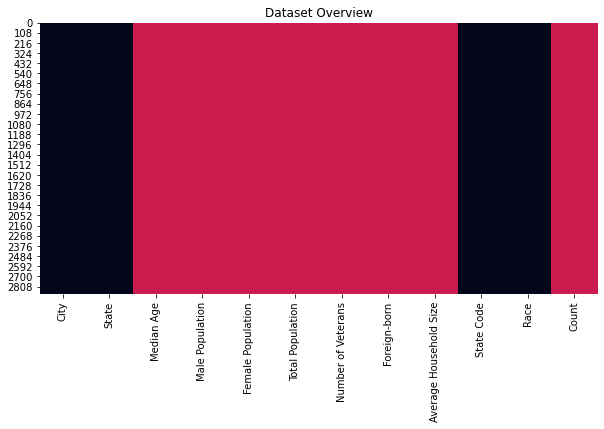

 Categerocial   Numerical   NaN 


In [91]:
dtf_overview(df_demographic, max_cat=10, figsize=(10,5))

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

### 3.1 Schema for Immigration Analysis
![schema](image/immigration.png)

- In this model, we don't consider the violet tables, like *i94cit_res, i94mode, temperature, demographic*. Otherwise, the analysis based on the fact table will be greatly affected.

- If we want to explore the relationship between temperature, urban population and immigration data, we can build another model

#### Fact Table
immigration - records with air transportation of immigrantion
- *cicid, year, month, airport_id, state_id, city, visa_id, admnum, longitude, latitude*

#### Dimension Table
i94port - code of destination city

i94addr - is where the immigrants resides in USA 

i94visa - reason for immigration

airport - information of airports in USA

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### 3.2 Steps
1. Create tables (**create_tables.py**)
2. Read data, explore and clean data, save data (**etl.py**)
3. Copy data to PostgreSQL (**airflow/dags/dag.py**)
4. Insert to fact table (**airflow/dags/dag.py**)
5. Analyse the fact table (**immigration_analysis.ipynb**)

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### **"airflow/dags/dag.py"**

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here
# **"airflow/dags/dag.py"**

run_quality_checks = DataQualityOperator(
    task_id='Run_data_quality_checks',
    dag=dag,
    dq_checks=[
        {'check_sql': "SELECT COUNT(*) FROM immigration WHERE cicid is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM immigrant WHERE admnum is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM i94cit_res WHERE i94cit_res is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM i94port WHERE i94port is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM i94mode WHERE i94mode is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM i94addr WHERE i94addr is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM i94visa WHERE i94visa is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM airport WHERE local_code is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM temperature WHERE averagetemperature is null", 'expected_result':0},
        {'check_sql': "SELECT COUNT(*) FROM demographic WHERE total_population is null", 'expected_result':0}
    ],
    table=('immigration', 'immigrant', 'i94cit_res', 'i94port', 'i94mode', 'i94addr', 'i94visa', 'airport', 'temperature', 'demographic'),
    redshift_conn_id="redshift"
)

### **"airflow/plugins/operators/data_quality.py"**
The operator's main functionality is to receive one or more SQL based test cases along with the expected results and execute the tests. 


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

**"Data_Dictionary.xlsx"**

### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

### 1. tools and technologies

Pandas - We use it to read and wirte files to dataframe.

Numpy, Matplotlib - We can use them to analyse the immigration and plot.

Pyspark - When we read a large amount of data, pandas is no longer applicable. At this time, we need to use pyspark.

### 2. 

Monthly. Because most of our analysis is done on a monthly basis.

### 3.

- The data was increased by 100x.

When the amount of data is small, we can use the traditional way to process it on the personal computer. Due to the scalability of redshift, we can also directly use redshift to store data, so that even if the data was increased by 100x, we don't have to worry about insufficient storage space, and use Hadoop cluster to calculate and analyze.

- The data populates a dashboard that must be updated on a daily basis by 7am every day.

Airflow is a programmable, scheduling and monitoring workflow platform.  Airflow provides rich command-line tools for system control, and its web management interface can also facilitate the control and scheduling of tasks, and real-time monitor the operation status of tasks. We can use airflow to schedule the execution time of tasks.

- The database needed to be accessed by 100+ people.

Traditional relational database can be contentedly used. However, in order to improve the access and reading efficiency, we can choose NoSQL, such as Cassandra.
